# Insights

Here, we want to get some insights into when the Trove mechanism helps and for which tasks it doesn't.

In [1]:
from insights import paths
choices = paths.choices

data_paths = paths.json_paths


[warning] tabmwp skipped (paths missing)
[warning] wtq skipped (paths missing)
[warning] hitab skipped (paths missing)
[warning] gqa skipped (paths missing)


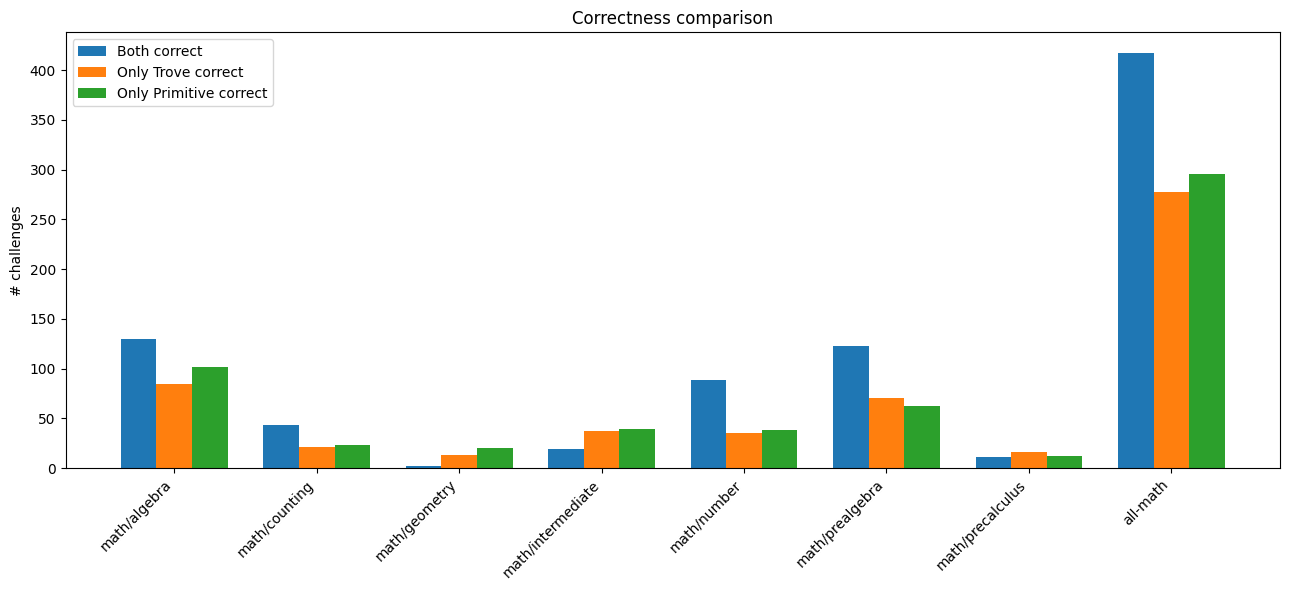

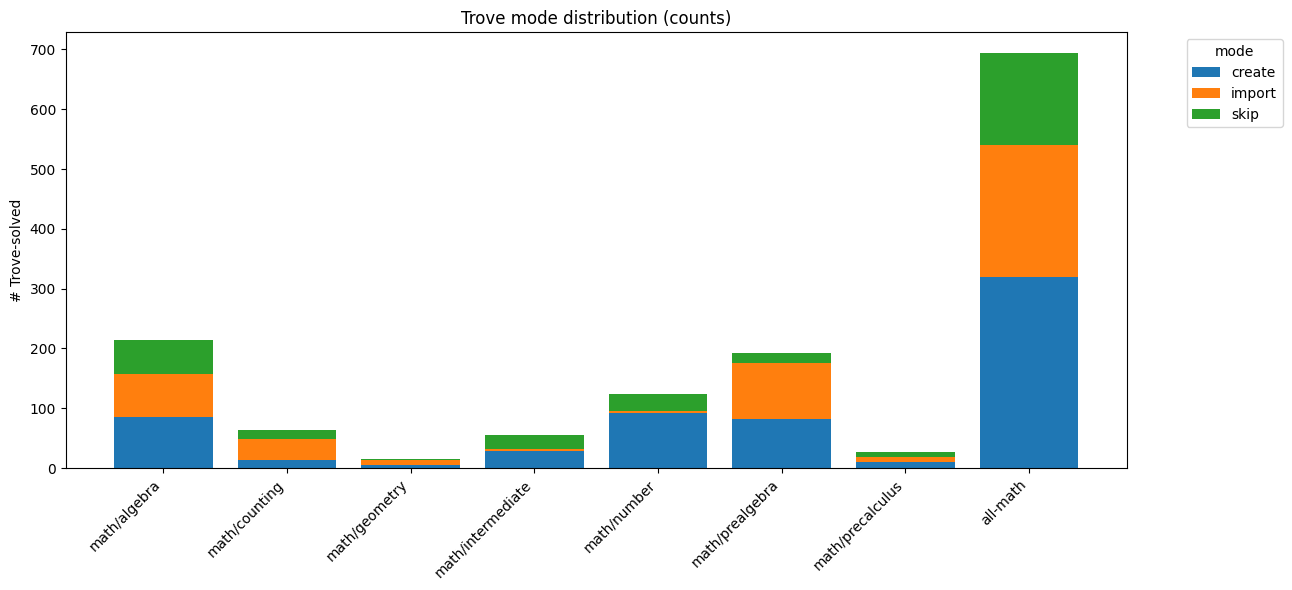

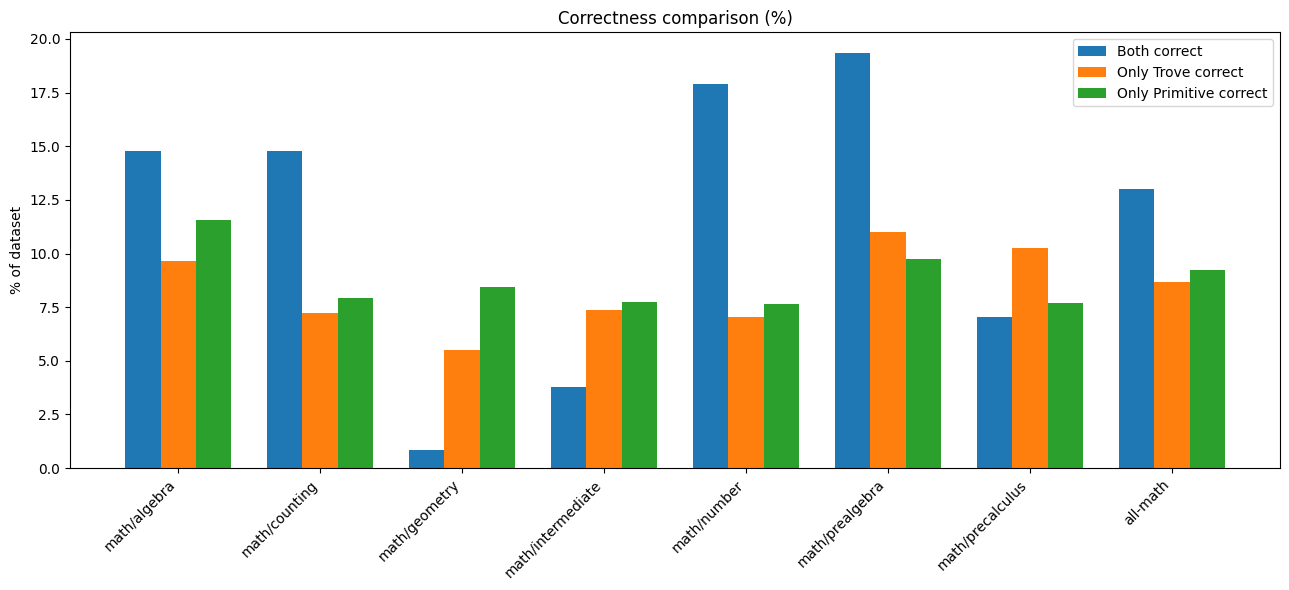

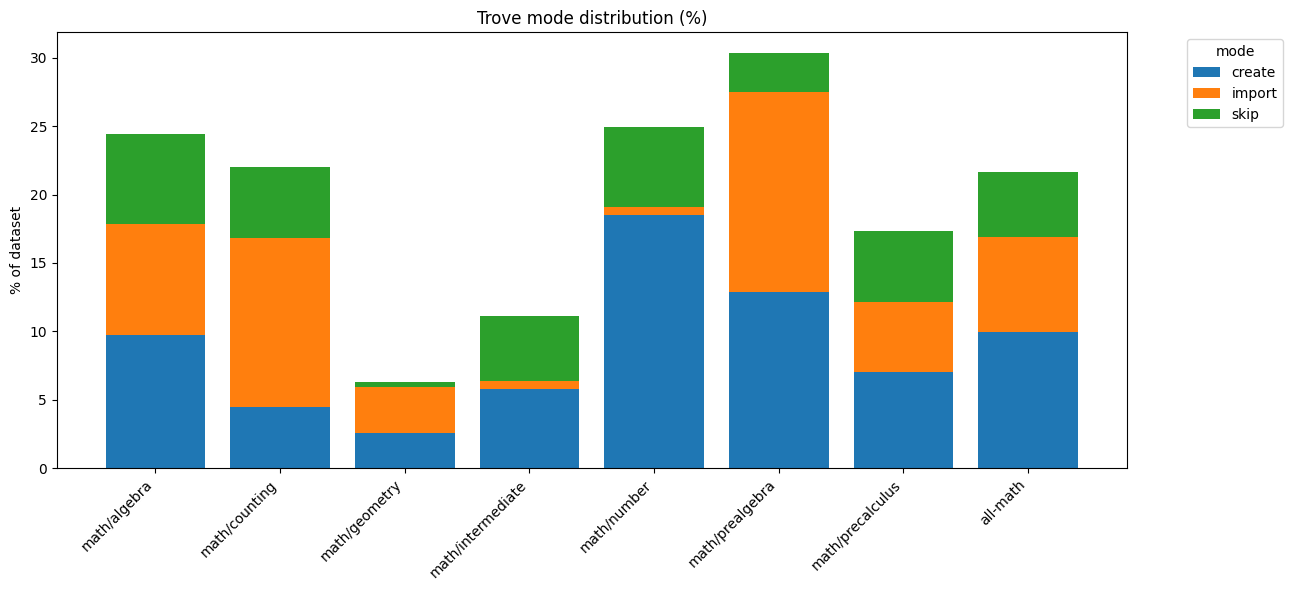

In [9]:
#!/usr/bin/env python
"""
Primitive vs Trove — overlap report & plots

* Figure 1   grouped bars         (absolute counts)
* Figure 2   stacked bars         (Trove‑mode counts)
* Figure 3   grouped bars         (percent of dataset)
* Figure 4   stacked bars         (Trove‑mode percentages)

Every figure now has a **right‑most column “all‑math”** that aggregates the
seven math sub‑domains.
"""
# ── Imports ───────────────────────────────────────────────────────────────────
import json, numpy as np
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List
import matplotlib.pyplot as plt


# ── 2.  containers ────────────────────────────────────────────────────────────
datasets, both_cnt, only_tr_cnt, only_pr_cnt = [], [], [], []
all_mode_counters, all_modes = {}, set()
dataset_totals = []

# ── 3.  per‑domain loop ───────────────────────────────────────────────────────
for ds in choices:
    if ds not in data_paths:
        print(f"[warning] {ds} skipped (paths missing)")
        continue

    prim_path, trove_path = data_paths[ds]
    primitive = json.loads(Path(prim_path).read_text())
    trove     = json.loads(Path(trove_path).read_text())

    both, only_tr, only_pr = set(), set(), set()
    for i in range(len(trove)):
        prim_ok = primitive[i]["is_correct"]
        trov_ok = trove[i]["response"]["is_correct"]
        if prim_ok and trov_ok:              both.add(i)
        elif trov_ok and not prim_ok:        only_tr.add(i)
        elif prim_ok and not trov_ok:        only_pr.add(i)

    # mode counts of **all** Trove‑correct cases
    modes = [trove[i]["mode"] for i in (both | only_tr)]
    mode_counter = Counter(modes)

    # store
    datasets.append(ds)
    both_cnt.append(len(both))
    only_tr_cnt.append(len(only_tr))
    only_pr_cnt.append(len(only_pr))
    all_mode_counters[ds] = mode_counter
    all_modes.update(mode_counter.keys())
    dataset_totals.append(len(trove))

# ── 4.  append aggregated “all‑math” column ───────────────────────────────────
datasets.append("all‑math")

both_cnt.append(sum(both_cnt))
only_tr_cnt.append(sum(only_tr_cnt))
only_pr_cnt.append(sum(only_pr_cnt))
dataset_totals.append(sum(dataset_totals))

agg_counter = Counter()
for c in all_mode_counters.values():
    agg_counter += c
all_mode_counters["all‑math"] = agg_counter

for mode in agg_counter:
    all_modes.add(mode)

# ── 5.  numpy helpers for plotting ────────────────────────────────────────────
totals   = np.array(dataset_totals, dtype=float)
x        = np.arange(len(datasets))
w        = 0.25

# ── 6.  Figure 1 — grouped counts ────────────────────────────────────────────
fig1, ax1 = plt.subplots(figsize=(13,6))
ax1.bar(x-w, both_cnt,            w, label="Both correct")
ax1.bar(x   , only_tr_cnt,        w, label="Only Trove correct")
ax1.bar(x+w, only_pr_cnt,         w, label="Only Primitive correct")
ax1.set_xticks(x); ax1.set_xticklabels(datasets, rotation=45, ha="right")
ax1.set_ylabel("# challenges"); ax1.set_title("Correctness comparison"); ax1.legend()
fig1.tight_layout()

# ── 7.  Figure 2 — stacked Trove‑mode counts ─────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(13,6))
bottom = np.zeros(len(datasets))
for m in sorted(all_modes):
    counts = [all_mode_counters[d].get(m,0) for d in datasets]
    ax2.bar(x, counts, bottom=bottom, label=m)
    bottom += counts
ax2.set_xticks(x); ax2.set_xticklabels(datasets, rotation=45, ha="right")
ax2.set_ylabel("# Trove‑solved"); ax2.set_title("Trove mode distribution (counts)")
ax2.legend(title="mode", bbox_to_anchor=(1.05,1), loc="upper left")
fig2.tight_layout()

# ── 8.  Figure 3 — grouped percentages ───────────────────────────────────────
pct_both  = 100 * np.array(both_cnt)      / totals
pct_trove = 100 * np.array(only_tr_cnt)   / totals
pct_prim  = 100 * np.array(only_pr_cnt)   / totals

fig3, ax3 = plt.subplots(figsize=(13,6))
ax3.bar(x-w, pct_both,  w, label="Both correct")
ax3.bar(x   , pct_trove,w, label="Only Trove correct")
ax3.bar(x+w, pct_prim,  w, label="Only Primitive correct")
ax3.set_xticks(x); ax3.set_xticklabels(datasets, rotation=45, ha="right")
ax3.set_ylabel("% of dataset"); ax3.set_title("Correctness comparison (%)"); ax3.legend()
fig3.tight_layout()

# ── 9.  Figure 4 — stacked Trove‑mode percentages ────────────────────────────
fig4, ax4 = plt.subplots(figsize=(13,6))
bottom = np.zeros(len(datasets))
for m in sorted(all_modes):
    counts = np.array([all_mode_counters[d].get(m,0) for d in datasets], dtype=float)
    perc   = 100 * counts / totals
    ax4.bar(x, perc, bottom=bottom, label=m)
    bottom += perc
ax4.set_xticks(x); ax4.set_xticklabels(datasets, rotation=45, ha="right")
ax4.set_ylabel("% of dataset"); ax4.set_title("Trove mode distribution (%)")
ax4.legend(title="mode", bbox_to_anchor=(1.05,1), loc="upper left")
fig4.tight_layout()

plt.show()

In [68]:
## TODO: genau das nur mit einem Orakelmodell. Zeigt, ob die Antworten generell anders sind, oder ob das Majority Voting etwas macht.


# ANALYSE:

#wir sehen, dass sich Trove und Primitive oftmals ergänzen -> vermutlich wegen verschiedenen Prompts -> warum schreiben wir nicht 15 verschiedene Prompts und samplen aus diesen?
# z.B. 15 verschiedene Beispiele mitgeben

# TODO: Bei Trove die similarity von Beispielen und der Task berechnen und schauen, ob das zu den gelösten Aufgaben passt!

# Oracle

In [4]:
import re
from pathlib import Path

def solved_examples(file_path: str | Path) -> list[int]:
    """
    Scan the plain-text results file and return the example numbers
    that have at least one `Is Answer Correct: True` entry.
    """
    file_path = Path(file_path)
    text = file_path.read_text(encoding="utf-8")

    # Grab each Example block, keeping its number.
    blocks = re.finditer(
        r"## Example (\d+)(.*?)(?=## Example |\Z)",  # non-greedy, up to next Example or EOF
        text,
        flags=re.S,
    )

    solved = []
    for m in blocks:
        ex_number, block = int(m.group(1)), m.group(2)
        # If any attempt inside the block was marked correct, keep the example.
        if re.search(r"Is Answer Correct:\s*True", block):
            solved.append(ex_number)

    return solved

path_to_file = "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211161927_2025-02-11-16-19-27.md"          # <-- replace with your file name
print(solved_examples(path_to_file))   # e.g.  [0, 2, 7, 9]

[0, 2, 4, 5, 6, 7, 11, 12, 14, 15, 17, 19, 20, 21, 22, 28, 30, 32, 34, 43, 44, 47, 49, 51, 57, 58, 66, 68, 73, 75, 76, 77, 81, 87, 92, 93, 96, 97, 99, 104, 105, 112, 115, 117, 123, 125, 129, 133, 136, 137, 142, 143, 144, 145, 152, 153, 154, 156, 164, 174, 175, 181, 184, 196, 197, 204, 207, 212, 214, 219, 223, 226, 233, 237, 241, 243, 252, 253, 254, 258, 259, 260, 264, 265, 266, 267, 270, 282, 283, 286]



=== MATH/ALGEBRA ===
  Both correct:             220 examples
  Only TROVE-Oracle:         65 examples
  Only PRIMITIVE-Oracle:    162 examples

=== MATH/COUNTING ===
  Both correct:              93 examples
  Only TROVE-Oracle:         34 examples
  Only PRIMITIVE-Oracle:     38 examples

=== MATH/GEOMETRY ===
  Both correct:              34 examples
  Only TROVE-Oracle:         28 examples
  Only PRIMITIVE-Oracle:     37 examples

=== MATH/INTERMEDIATE ===
  Both correct:              77 examples
  Only TROVE-Oracle:         58 examples
  Only PRIMITIVE-Oracle:     45 examples

=== MATH/NUMBER ===
  Both correct:             182 examples
  Only TROVE-Oracle:         44 examples
  Only PRIMITIVE-Oracle:     70 examples

=== MATH/PREALGEBRA ===
  Both correct:             270 examples
  Only TROVE-Oracle:         94 examples
  Only PRIMITIVE-Oracle:     46 examples

=== MATH/PRECALCULUS ===
  Both correct:              37 examples
  Only TROVE-Oracle:         11 examples
  Only PRIMIT

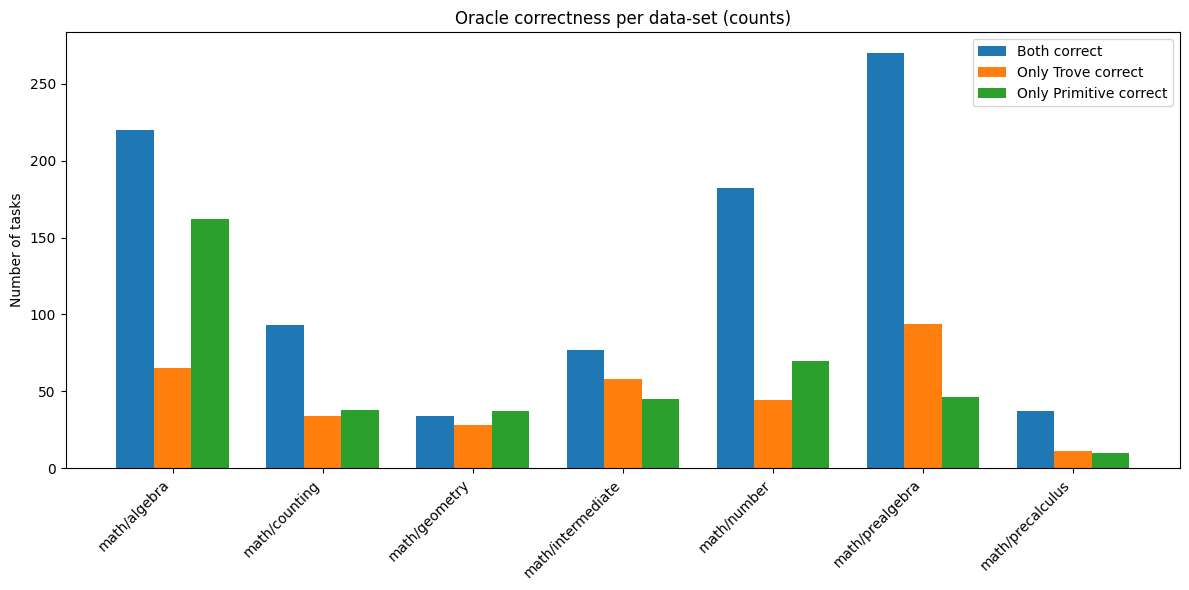

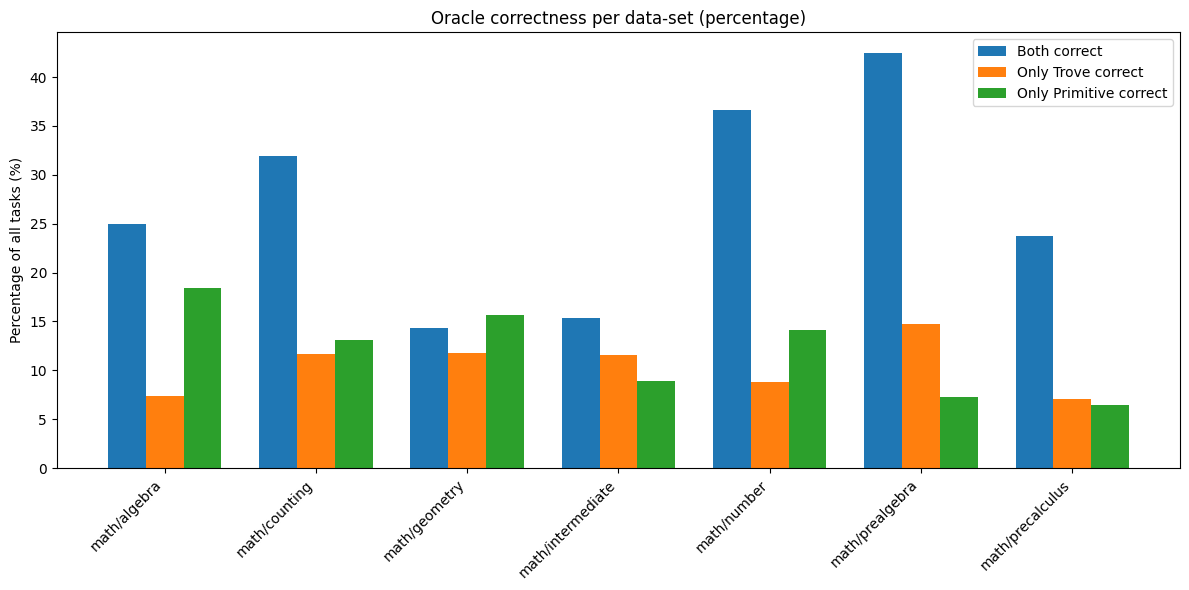

In [7]:
#!/usr/bin/env python
"""
Overlap of   • PRIMITIVE-Oracle   vs   • TROVE-Oracle
on result files written in *Markdown* that contain every solution attempt.

For Trove the same example appears three times (one per mode).  An example is
counted as *solved by Trove* if **any** of those three blocks – or any attempt
inside them – carries “Is Answer Correct: True”.
"""
from __future__ import annotations
import re
from pathlib import Path
from typing import Dict, List, Set

import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 1.  DATA-SET REGISTRY  –  ***EDIT YOUR PATHS HERE***
#     Each value:  [primitive_oracle_md, trove_oracle_md]      ← order matters
# ──────────────────────────────────────────────────────────────────────────────
choices = [
    "math/algebra", "math/counting", "math/geometry",
    "math/intermediate", "math/number",
    "math/prealgebra", "math/precalculus",
    #"tabmwp", "wtq", "hitab", "gqa"
]

data_paths: Dict[str, List[str]] = {
    "math/algebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/primitive/run20250211162307_2025-02-11-16-23-07.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run20250211225721_2025-02-11-22-57-21.md",
    ],
    "math/counting": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211155451_2025-02-11-15-54-51.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md"
    ],
    "math/geometry": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155050_2025-02-11-15-50-50.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md"
    ],
    "math/intermediate": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/primitive/run20250212035420_2025-02-12-03-54-20.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/trove/copy_of_run20250212060318.md"
    ],
    "math/number": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/primitive/run20250211183137_2025-02-11-18-31-37.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/trove/run20250212023156_2025-02-12-02-31-56.md"
    ],
    "math/prealgebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/primitive/run20250211205325_2025-02-11-20-53-25.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/trove/run20250212023740_2025-02-12-02-37-40.md"
    ],
    "math/precalculus": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/primitive/run20250211140654_2025-02-11-14-06-54.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/trove/run20250212031007_2025-02-12-03-10-07.md"
    ],

    # … fill in the rest …
}

# ──────────────────────────────────────────────────────────────────────────────
# 1.  MARKDOWN PARSER
# ──────────────────────────────────────────────────────────────────────────────
EXAMPLE_BLOCK = re.compile(
    r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", flags=re.S | re.I
)
CORRECT_FLAG = re.compile(r"Is Answer Correct:\s*True", flags=re.I)

def solved_examples(md_path: str | Path) -> Set[int]:
    """
    Return {example-idx} solved in this .md file (any attempt True in its block).
    Works for Primitive (.md has one block per example) and Trove (three blocks).
    """
    solved: Set[int] = set()
    text = Path(md_path).read_text(encoding="utf-8")
    for ex, block in EXAMPLE_BLOCK.findall(text):
        if CORRECT_FLAG.search(block):
            solved.add(int(ex))
    return solved

def all_examples(md_path: str | Path) -> Set[int]:
    "Set of *every* Example index present in the file."
    text = Path(md_path).read_text(encoding="utf-8")
    return {int(ex) for ex, _ in EXAMPLE_BLOCK.findall(text)}

# ──────────────────────────────────────────────────────────────────────────────
# 2.  MAIN LOOP – collect numbers for printing and plotting
# ──────────────────────────────────────────────────────────────────────────────
datasets                       = []    # x-axis labels
both_counts                    = []    # y1
only_trove_counts              = []    # y2
only_primitive_counts          = []    # y3
dataset_totals                 = []    # denominators for % plot

for ds in choices:
    if ds not in data_paths:
        print(f"[warning] {ds} – paths missing; skipped.")
        continue

    prim_md, trove_md = data_paths[ds]

    prim_ok    = solved_examples(prim_md)
    trove_ok   = solved_examples(trove_md)
    all_ids    = all_examples(prim_md) | all_examples(trove_md)

    both          = prim_ok & trove_ok
    only_trove    = trove_ok   - prim_ok
    only_prim     = prim_ok    - trove_ok

    # store for plots
    datasets.append(ds)
    both_counts.append(len(both))
    only_trove_counts.append(len(only_trove))
    only_primitive_counts.append(len(only_prim))
    dataset_totals.append(len(all_ids))

    # console out-print
    print(f"\n=== {ds.upper()} ===")
    print(f"  Both correct:            {len(both):>4} examples")
    print(f"  Only TROVE-Oracle:       {len(only_trove):>4} examples")
    print(f"  Only PRIMITIVE-Oracle:   {len(only_prim):>4} examples")

# ──────────────────────────────────────────────────────────────────────────────
# 3.  PLOTTING
# ──────────────────────────────────────────────────────────────────────────────
x          = np.arange(len(datasets))
w          = 0.25                        # bar width

# Fig 1 – absolute counts
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(x - w, both_counts,          width=w, label="Both correct")
ax1.bar(x,      only_trove_counts,   width=w, label="Only Trove correct")
ax1.bar(x + w,  only_primitive_counts, width=w, label="Only Primitive correct")
ax1.set_xticks(x)
ax1.set_xticklabels(datasets, rotation=45, ha="right")
ax1.set_ylabel("Number of tasks")
ax1.set_title("Oracle correctness per data-set (counts)")
ax1.legend()
fig1.tight_layout()

# Fig 2 – percentages of all tasks
totals         = np.array(dataset_totals)
pct_both       = 100 * np.array(both_counts)          / totals
pct_trove      = 100 * np.array(only_trove_counts)    / totals
pct_primitive  = 100 * np.array(only_primitive_counts)/ totals

fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.bar(x - w, pct_both,       width=w, label="Both correct")
ax2.bar(x,      pct_trove,     width=w, label="Only Trove correct")
ax2.bar(x + w,  pct_primitive, width=w, label="Only Primitive correct")
ax2.set_xticks(x)
ax2.set_xticklabels(datasets, rotation=45, ha="right")
ax2.set_ylabel("Percentage of all tasks (%)")
ax2.set_title("Oracle correctness per data-set (percentage)")
ax2.legend()
fig2.tight_layout()

plt.show()

In [ ]:
 #!/usr/bin/env python
"""
Primitive‑oracle  vs Trove‑oracle • with “all‑math” column appended.
"""

from __future__ import annotations
import re, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from typing  import Dict, List, Set

# … keep your `choices` and `data_paths` exactly as defined …

# ── Markdown helpers ─────────────────────────────────────────────────────────
EXAMPLE = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S|re.I)
CORRECT = re.compile(r"Is Answer Correct:\s*True", re.I)

def solved_examples(md: str|Path) -> Set[int]:
    txt = Path(md).read_text("utf-8")
    return {int(i) for i,blk in EXAMPLE.findall(txt) if CORRECT.search(blk)}

def all_examples(md: str|Path) -> Set[int]:
    txt = Path(md).read_text("utf-8")
    return {int(i) for i,_ in EXAMPLE.findall(txt)}

# ── 1. per‑dataset counts ────────────────────────────────────────────────────
datasets, both, tr_only, pr_only, totals = [], [], [], [], []

for ds in choices:
    if ds not in data_paths:
        print(f"[warning] {ds} skipped"); continue

    prim_md, trove_md = data_paths[ds]
    p_ok  = solved_examples(prim_md)
    t_ok  = solved_examples(trove_md)
    ids   = all_examples(prim_md) | all_examples(trove_md)

    datasets.append(ds)
    both .append(len(p_ok & t_ok))
    tr_only.append(len(t_ok - p_ok))
    pr_only.append(len(p_ok - t_ok))
    totals.append(len(ids))

# ── 2. append aggregated “all‑math” row --------------------------------------
datasets.append("all‑math")
both.append(sum(both))
tr_only.append(sum(tr_only))
pr_only.append(sum(pr_only))
totals.append(sum(totals))

# ── 3. plotting --------------------------------------------------------------
x = np.arange(len(datasets)); w = .25

# Figure 1  (absolute counts)
fig1,ax1 = plt.subplots(figsize=(12,6))
ax1.bar(x-w, both   , w, label="Both correct")
ax1.bar(x   , tr_only, w, label="Only Trove correct")
ax1.bar(x+w, pr_only, w, label="Only Primitive correct")
ax1.set_xticks(x); ax1.set_xticklabels(datasets, rotation=45, ha="right")
ax1.set_ylabel("# tasks"); ax1.set_title("Oracle correctness – counts"); ax1.legend()
fig1.tight_layout()

# Figure 2  (percent of dataset)
tot_arr = np.array(totals, dtype=float)
pct_both  = 100 * np.array(both   ) / tot_arr
pct_tr    = 100 * np.array(tr_only) / tot_arr
pct_pr    = 100 * np.array(pr_only) / tot_arr

fig2,ax2 = plt.subplots(figsize=(12,6))
ax2.bar(x-w, pct_both, w, label="Both correct")
ax2.bar(x   , pct_tr , w, label="Only Trove correct")
ax2.bar(x+w, pct_pr , w, label="Only Primitive correct")
ax2.set_xticks(x); ax2.set_xticklabels(datasets, rotation=45, ha="right")
ax2.set_ylabel("% of dataset"); ax2.set_title("Oracle correctness – percentage"); ax2.legend()
fig2.tight_layout()

plt.show()

### Analysing different modi and primitive with k=5 (this is important for Primitive)

In [12]:
#!/usr/bin/env python
"""
Primitive-Oracle   vs   Trove-Oracle (split into import / create / skip modes)

A Trove-Oracle .md file contains *three* blocks for each example, one per mode.
The script:
  • extracts every ## Example k block,
  • classifies the block as  import / create / skip,
  • decides whether that block solved the example,
  • aggregates per-mode oracle sets,
  • compares each mode against the Primitive oracle.
"""
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List, Set

# ──────────────────────────────────────────────────────────────────────────────
# 1.  CONFIGURE YOUR DATA SET PATHS HERE
# ──────────────────────────────────────────────────────────────────────────────
choices = [
    "math/algebra", "math/counting", "math/geometry",
    "math/intermediate", "math/number",
    "math/prealgebra", "math/precalculus",
    "tabmwp", "wtq", "hitab", "gqa"
]

data_paths: Dict[str, List[str]] = {
    #  [primitive_oracle_md, trove_oracle_md]
    "math/algebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/primitive/run0.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run20250211225721_2025-02-11-22-57-21.md",
    ],
    "math/counting": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211161927_2025-02-11-16-19-27.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md"
    ],
    "math/geometry": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155047_2025-02-11-15-50-47.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md"
    ],
    "math/intermediate": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/primitive/run20250212051129_2025-02-12-05-11-29.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/trove/copy_of_run20250212060318.md"
    ],
    "math/number": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/primitive/run20250211191905_2025-02-11-19-19-05.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/trove/run20250212023156_2025-02-12-02-31-56.md"
    ],
    "math/prealgebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/primitive/run20250211201300_2025-02-11-20-13-00.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/trove/run20250212023740_2025-02-12-02-37-40.md"
    ],
    "math/precalculus": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/primitive/run20250210130235_2025-02-10-13-02-35.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/trove/run20250212031007_2025-02-12-03-10-07.md"
    ],
    # … fill in the rest …
}

# ──────────────────────────────────────────────────────────────────────────────
# 1.  MARKDOWN HELPERS
# ──────────────────────────────────────────────────────────────────────────────
EXAMPLE_BLOCK = re.compile(
    r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", flags=re.S | re.I
)
CORRECT_FLAG = re.compile(r"Is Answer Correct:\s*True", flags=re.I)

def primitive_oracle(md_path: str | Path) -> Set[int]:
    "Examples solved by the Primitive oracle (single block per example)."
    text = Path(md_path).read_text(encoding="utf-8")
    return {int(ex) for ex, block in EXAMPLE_BLOCK.findall(text)
            if CORRECT_FLAG.search(block)}

def trove_oracle_by_mode(md_path: str | Path) -> Dict[str, Set[int]]:
    """
    Return {'create': …, 'import': …, 'skip': …} – examples solved per mode,
    determined by the *order* of appearance:
        1st block of k → create,  2nd → import,  3rd → skip
    """
    ORDER = ("create", "import", "skip")
    seen_count: dict[int, int] = {}          # k → how many blocks have we seen

    solved = {m: set() for m in ORDER}

    text = Path(md_path).read_text(encoding="utf-8")
    for ex_str, block in EXAMPLE_BLOCK.findall(text):
        ex = int(ex_str)
        idx = seen_count.get(ex, 0)          # 0, 1, 2 …
        if idx < 3:                          # ignore any accidental extras
            mode = ORDER[idx]
            if CORRECT_FLAG.search(block):
                solved[mode].add(ex)
        seen_count[ex] = idx + 1             # advance counter

    return solved

# ──────────────────────────────────────────────────────────────────────────────
# 2.  REPORT
# ──────────────────────────────────────────────────────────────────────────────
for ds in choices:
    if ds not in data_paths:
        print(f"[warning] {ds} – paths missing; skipping.")
        continue

    primitive_md, trove_md = data_paths[ds]

    prim_ok          = primitive_oracle(primitive_md)
    trove_ok_by_mode = trove_oracle_by_mode(trove_md)

    print(f"\n=== {ds.upper()} ===")
    print(f"  PRIMITIVE-Oracle solved: {len(prim_ok)} examples")

    for mode in ("create", "import", "skip"):
        mode_ok   = trove_ok_by_mode[mode]
        both      = prim_ok & mode_ok
        only_mode = mode_ok - prim_ok
        only_prim = prim_ok - mode_ok

        print(f"  ─ {mode.capitalize():<7}mode ─────────────")
        print(f"      Both correct:          {len(both):>4}")
        print(f"      Only {mode.capitalize():<7}correct:  {len(only_mode):>4}")
        print(f"      Only Primitive:        {len(only_prim):>4}")


=== MATH/ALGEBRA ===
  PRIMITIVE-Oracle solved: 90 examples
  ─ Create mode ─────────────
      Both correct:            27
      Only Create correct:   181
      Only Primitive:          63
  ─ Import mode ─────────────
      Both correct:            42
      Only Import correct:   277
      Only Primitive:          48
  ─ Skip   mode ─────────────
      Both correct:            22
      Only Skip   correct:   196
      Only Primitive:          68

=== MATH/COUNTING ===
  PRIMITIVE-Oracle solved: 90 examples
  ─ Create mode ─────────────
      Both correct:            52
      Only Create correct:    28
      Only Primitive:          38
  ─ Import mode ─────────────
      Both correct:            60
      Only Import correct:    36
      Only Primitive:          30
  ─ Skip   mode ─────────────
      Both correct:            48
      Only Skip   correct:    18
      Only Primitive:          42

=== MATH/GEOMETRY ===
  PRIMITIVE-Oracle solved: 37 examples
  ─ Create mode ─────────────

In [15]:
data_paths

{'math/algebra': ['/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211161927_2025-02-11-16-19-27.md',
  '/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run20250211225721_2025-02-11-22-57-21.md'],
 'math/counting': ['/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211161927_2025-02-11-16-19-27.md',
  '/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md'],
 'math/geometry': ['/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155047_2025-02-11-15-50-47.md',
  '/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md'],
 'math/intermediate': ['

╭─────────────────────────────────────────────────────────────
│ MATH/ALGEBRA    | Primitive:  223 | Both 188 | Trove‑only 219 (create 108/import 157/skip  85) | Primitive‑only  35
│ MATH/COUNTING   | Primitive:   90 | Both  73 | Trove‑only  54 (create  28/import  36/skip  18) | Primitive‑only  17
│ MATH/GEOMETRY   | Primitive:   37 | Both  21 | Trove‑only  41 (create  16/import  18/skip  17) | Primitive‑only  16
│ MATH/INTERMEDIATE | Primitive:   83 | Both  55 | Trove‑only  78 (create  12/import  47/skip  35) | Primitive‑only  28
│ MATH/NUMBER     | Primitive:  181 | Both 149 | Trove‑only  75 (create   3/import  48/skip  42) | Primitive‑only  32
│ MATH/PREALGEBRA | Primitive:  232 | Both 203 | Trove‑only 161 (create  90/import  98/skip  89) | Primitive‑only  29
│ MATH/PRECALCULUS | Primitive:   26 | Both  24 | Trove‑only  24 (create  12/import  15/skip   9) | Primitive‑only   2
│ [warning] tabmwp          paths missing – skipped.
│ [warning] wtq             paths missing – skipped.
│ 

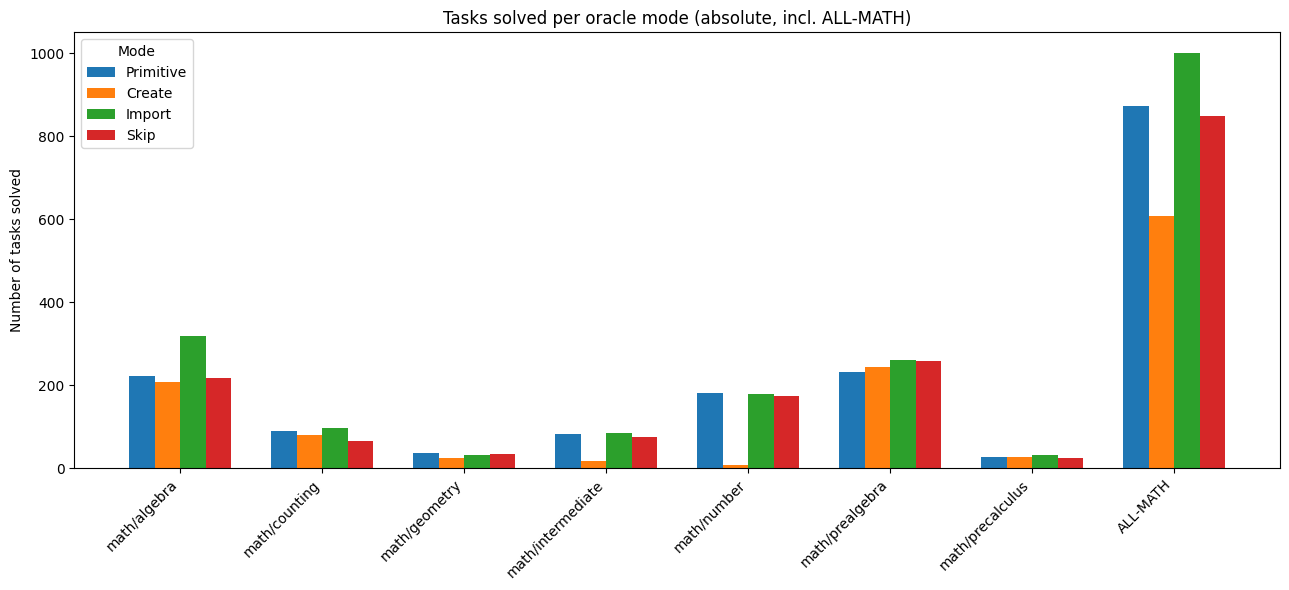

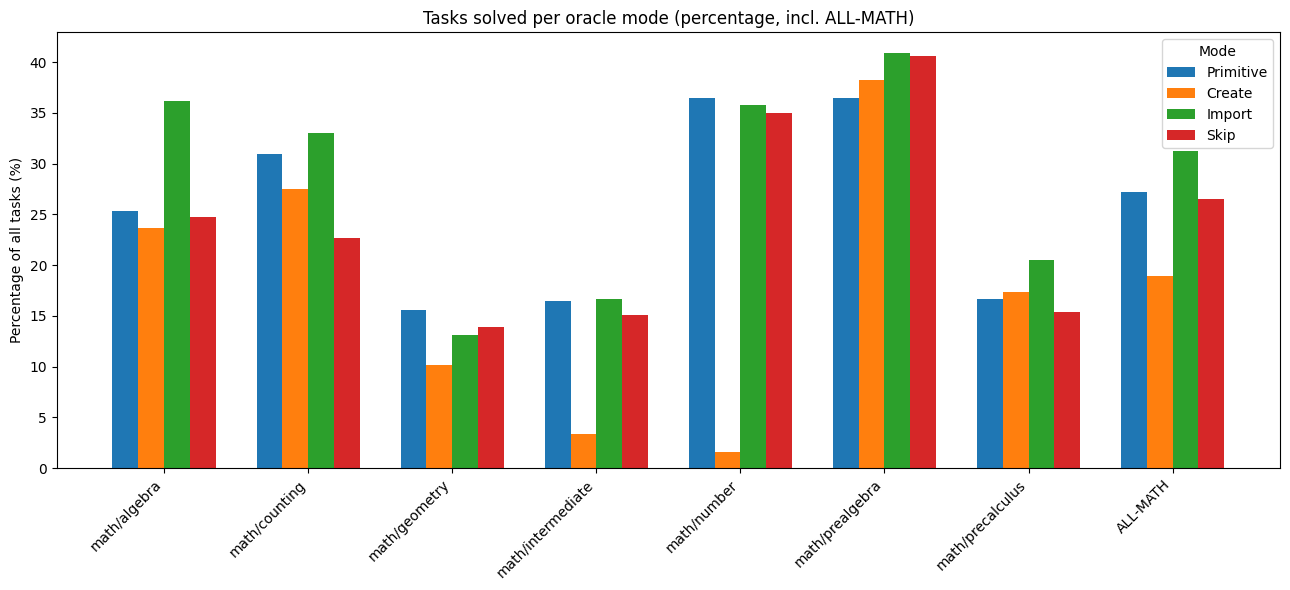

In [2]:
# ----------------------------------------------------------------------------------
# 1.  Imports ───────────────────────────────────────────────────────────────────────
# ----------------------------------------------------------------------------------
from __future__ import annotations
from pathlib import Path
from collections import Counter
import hashlib, json, os, re, datetime
import numpy as np
import matplotlib.pyplot as plt

# Jupyter nicety
%matplotlib inline

choices = [
    "math/algebra", "math/counting", "math/geometry",
    "math/intermediate", "math/number",
    "math/prealgebra", "math/precalculus",
    "tabmwp", "wtq", "hitab", "gqa"
]

data_paths: Dict[str, List[str]] = {
    #  [primitive_oracle_md, trove_oracle_md]
    "math/algebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/primitive/run20250502162858_2025-05-02-16-28-58.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run20250211225721_2025-02-11-22-57-21.md",
    ],
    "math/counting": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211161927_2025-02-11-16-19-27.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md"
    ],
    "math/geometry": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155047_2025-02-11-15-50-47.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md"
    ],
    "math/intermediate": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/primitive/run20250212051129_2025-02-12-05-11-29.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/trove/copy_of_run20250212060318.md"
    ],
    "math/number": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/primitive/run20250211191905_2025-02-11-19-19-05.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/trove/run20250212023156_2025-02-12-02-31-56 copy.md"
    ],
    "math/prealgebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/primitive/run20250211201300_2025-02-11-20-13-00.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/trove/run20250212023740_2025-02-12-02-37-40.md"
    ],
    "math/precalculus": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/primitive/run20250210130235_2025-02-10-13-02-35.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/trove/run20250212031007_2025-02-12-03-10-07.md"
    ],
    # … fill in the rest …
}


# ----------------------------------------------------------------------------------
# 2.  Cache helpers ────────────────────────────────────────────────────────────────
# ----------------------------------------------------------------------------------
EX_BLOCK  = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S | re.I)
CORRECT   = re.compile(r"Is Answer Correct:\s*True", re.I)

CACHE_DIR = Path.home() / ".cache" / "modi_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def _md_hash(md_path: str | Path) -> str:
    return hashlib.md5(Path(md_path).read_bytes()).hexdigest()

def _primitive_parse(md_path: str | Path) -> set[int]:
    text = Path(md_path).read_text(encoding="utf-8")
    return {int(ex) for ex, blk in EX_BLOCK.findall(text) if CORRECT.search(blk)}

def _trove_parse(md_path: str | Path) -> dict[str, set[int]]:
    ORDER, seen = ("create", "import", "skip"), {}
    solved = {m: set() for m in ORDER}
    text   = Path(md_path).read_text(encoding="utf-8")
    for ex_str, blk in EX_BLOCK.findall(text):
        ex   = int(ex_str)
        idx  = seen.get(ex, 0)
        if idx < 3:
            mode = ORDER[idx]
            if CORRECT.search(blk):
                solved[mode].add(ex)
        seen[ex] = idx + 1
    return solved

def load_or_parse(md_path: str | Path, kind: str):
    """
    kind = 'primitive'  → set[int]
    kind = 'trove'      → dict[str, set[int]]
    """
    md_path   = Path(md_path)
    cachefile = CACHE_DIR / f"{md_path.name}.{_md_hash(md_path)}.{kind}.json"

    if cachefile.exists():
        with cachefile.open() as f:
            data = json.load(f)
        return set(data) if kind == "primitive" else {k: set(v) for k, v in data.items()}

    # miss → parse & save
    parsed = _primitive_parse(md_path) if kind == "primitive" else _trove_parse(md_path)
    serial = list(parsed) if kind == "primitive" else {k: list(v) for k, v in parsed.items()}
    json.dump(serial, cachefile.open("w"))
    return parsed

# ----------------------------------------------------------------------------------
# 3.  Main analysis loop ───────────────────────────────────────────────────────────
# ----------------------------------------------------------------------------------
datasets                       = []
both_correct_counts            = []
only_trove_correct_counts      = []
only_primitive_correct_counts  = []
trove_mode_counters            = {}
all_modes                      = set()
dataset_totals                 = []

print("╭─────────────────────────────────────────────────────────────")
for ds in choices:
    if ds not in data_paths:
        print(f"│ [warning] {ds:<15} paths missing – skipped.")
        continue

    prim_md, trove_md = data_paths[ds]
    prim_ok           = load_or_parse(prim_md,  "primitive")
    trove_ok_by_mod   = load_or_parse(trove_md, "trove")
    trove_ok          = set().union(*trove_ok_by_mod.values())

    both        = prim_ok & trove_ok
    only_trove  = trove_ok  - prim_ok
    only_prim   = prim_ok   - trove_ok

    datasets.append(ds)
    both_correct_counts.append(len(both))
    only_trove_correct_counts.append(len(only_trove))
    only_primitive_correct_counts.append(len(only_prim))

    mc = Counter({m: len(exs & only_trove) for m, exs in trove_ok_by_mod.items()})
    trove_mode_counters[ds] = mc
    all_modes.update(mc)

    total_ids = len({int(m.group(1)) for m in EX_BLOCK.finditer(Path(prim_md).read_text(encoding="utf-8"))})
    dataset_totals.append(total_ids)

    # ─ text report line ─
    print(f"│ {ds.upper():<15} | Primitive: {len(prim_ok):>4} | "
          f"Both {len(both):>3} | Trove‑only {len(only_trove):>3} "
          f"(create {mc['create']:>3}/import {mc['import']:>3}/skip {mc['skip']:>3}) "
          f"| Primitive‑only {len(only_prim):>3}")
print("╰─────────────────────────────────────────────────────────────")

dataset_totals = np.array(dataset_totals)

# snapshot for quick reuse elsewhere (optional)
snapshot = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "datasets": datasets,
    "both_correct": both_correct_counts,
    "only_trove":  only_trove_correct_counts,
    "only_primitive": only_primitive_correct_counts,
    "trove_mode": {d: dict(c) for d, c in trove_mode_counters.items()},
    "totals": dataset_totals.tolist()
}
with open("oracle_snapshot.json", "w") as f:
    json.dump(snapshot, f, indent=2)

# ----------------------------------------------------------------------------------
# 4.  Plotting ──────────────────────────────────────────────────────────────────────
# ----------------------------------------------------------------------------------

modes = ["primitive", "create", "import", "skip"]

# ── absolute counts for each dataset ──────────────────────────────────────────────
abs_counts = {
    "primitive": np.array([len(load_or_parse(data_paths[d][0], "primitive"))              for d in datasets]),
    "create":    np.array([len(load_or_parse(data_paths[d][1], "trove")["create"])        for d in datasets]),
    "import":    np.array([len(load_or_parse(data_paths[d][1], "trove")["import"])        for d in datasets]),
    "skip":      np.array([len(load_or_parse(data_paths[d][1], "trove")["skip"])          for d in datasets]),
}

# ── add ALL‑MATH column ───────────────────────────────────────────────────────────
total_tasks_all = dataset_totals.sum()
datasets_plus   = datasets + ["ALL‑MATH"]
x               = np.arange(len(datasets_plus))
bar_w           = 0.18

for m in modes:
    overall = abs_counts[m].sum()
    abs_counts[m] = np.append(abs_counts[m], overall)

# ── figure A – absolute numbers ───────────────────────────────────────────────────
figA, axA = plt.subplots(figsize=(13, 6))
for i, m in enumerate(modes):
    axA.bar(x + (i-1.5)*bar_w, abs_counts[m], width=bar_w, label=m.capitalize())

axA.set_xticks(x)
axA.set_xticklabels(datasets_plus, rotation=45, ha="right")
axA.set_ylabel("Number of tasks solved")
axA.set_title("Tasks solved per oracle mode (absolute, incl. ALL‑MATH)")
axA.legend(title="Mode")
figA.tight_layout()

# ── figure B – percentages ────────────────────────────────────────────────────────
pct_counts = {m: 100*abs_counts[m]/np.append(dataset_totals, total_tasks_all) for m in modes}

figB, axB = plt.subplots(figsize=(13, 6))
for i, m in enumerate(modes):
    axB.bar(x + (i-1.5)*bar_w, pct_counts[m], width=bar_w, label=m.capitalize())

axB.set_xticks(x)
axB.set_xticklabels(datasets_plus, rotation=45, ha="right")
axB.set_ylabel("Percentage of all tasks (%)")
axB.set_title("Tasks solved per oracle mode (percentage, incl. ALL‑MATH)")
axB.legend(title="Mode")
figB.tight_layout()

plt.show()
# x         = np.arange(len(datasets))
# bar_w     = 0.25

# # Figure 1  – grouped counts
# fig1, ax1 = plt.subplots(figsize=(12, 6))
# ax1.bar(x - bar_w, both_correct_counts,           width=bar_w, label="Both correct")
# ax1.bar(x,           only_trove_correct_counts,   width=bar_w, label="Only Trove correct")
# ax1.bar(x + bar_w,   only_primitive_correct_counts, width=bar_w, label="Only Primitive correct")
# ax1.set_xticks(x); ax1.set_xticklabels(datasets, rotation=45, ha="right")
# ax1.set_ylabel("Number of tasks"); ax1.set_title("Oracle correctness per dataset")
# ax1.legend(); fig1.tight_layout()

# # Figure 2  – Trove-only stacked counts
# fig2, ax2 = plt.subplots(figsize=(12, 6))
# bottom = np.zeros(len(datasets))
# for mode in sorted(all_modes):
#     counts = [trove_mode_counters[d].get(mode, 0) for d in datasets]
#     ax2.bar(x, counts, bottom=bottom, label=mode); bottom += counts
# ax2.set_xticks(x); ax2.set_xticklabels(datasets, rotation=45, ha="right")
# ax2.set_ylabel("Number of tasks (Trove‑only)")
# ax2.set_title("Trove‑only oracle successes: mode distribution")
# ax2.legend(title="Trove mode", bbox_to_anchor=(1.05, 1), loc="upper left")
# fig2.tight_layout()

# # Figure 3  – grouped percentages
# pct_both      = 100 * np.array(both_correct_counts)          / dataset_totals
# pct_trove     = 100 * np.array(only_trove_correct_counts)    / dataset_totals
# pct_primitive = 100 * np.array(only_primitive_correct_counts)/ dataset_totals
# fig3, ax3 = plt.subplots(figsize=(12, 6))
# ax3.bar(x - bar_w, pct_both,      width=bar_w, label="Both correct")
# ax3.bar(x,           pct_trove,   width=bar_w, label="Only Trove correct")
# ax3.bar(x + bar_w,   pct_primitive, width=bar_w, label="Only Primitive correct")
# ax3.set_xticks(x); ax3.set_xticklabels(datasets, rotation=45, ha="right")
# ax3.set_ylabel("Percentage of all tasks (%)")
# ax3.set_title("Oracle correctness per dataset (percentage)")
# ax3.legend(); fig3.tight_layout()

# # Figure 4  – Trove-only percentages
# fig4, ax4 = plt.subplots(figsize=(12, 6))
# bottom = np.zeros(len(datasets))
# for mode in sorted(all_modes):
#     counts = np.array([trove_mode_counters[d].get(mode, 0) for d in datasets])
#     ax4.bar(x, 100*counts/dataset_totals, bottom=bottom, label=mode)
#     bottom += 100*counts/dataset_totals
# ax4.set_xticks(x); ax4.set_xticklabels(datasets, rotation=45, ha="right")
# ax4.set_ylabel("Percentage of all tasks (%)")
# ax4.set_title("Trove‑only oracle mode distribution (percentage)")
# ax4.legend(title="Trove mode", bbox_to_anchor=(1.05, 1), loc="upper left")
# fig4.tight_layout()

# plt.show()

[warning] math/counting: no paths given – skipped.
[warning] math/geometry: no paths given – skipped.
[warning] math/intermediate: no paths given – skipped.
[warning] math/number: no paths given – skipped.
[warning] math/prealgebra: no paths given – skipped.
[warning] math/precalculus: no paths given – skipped.
[warning] tabmwp: no paths given – skipped.
[warning] wtq: no paths given – skipped.
[warning] hitab: no paths given – skipped.
[warning] gqa: no paths given – skipped.


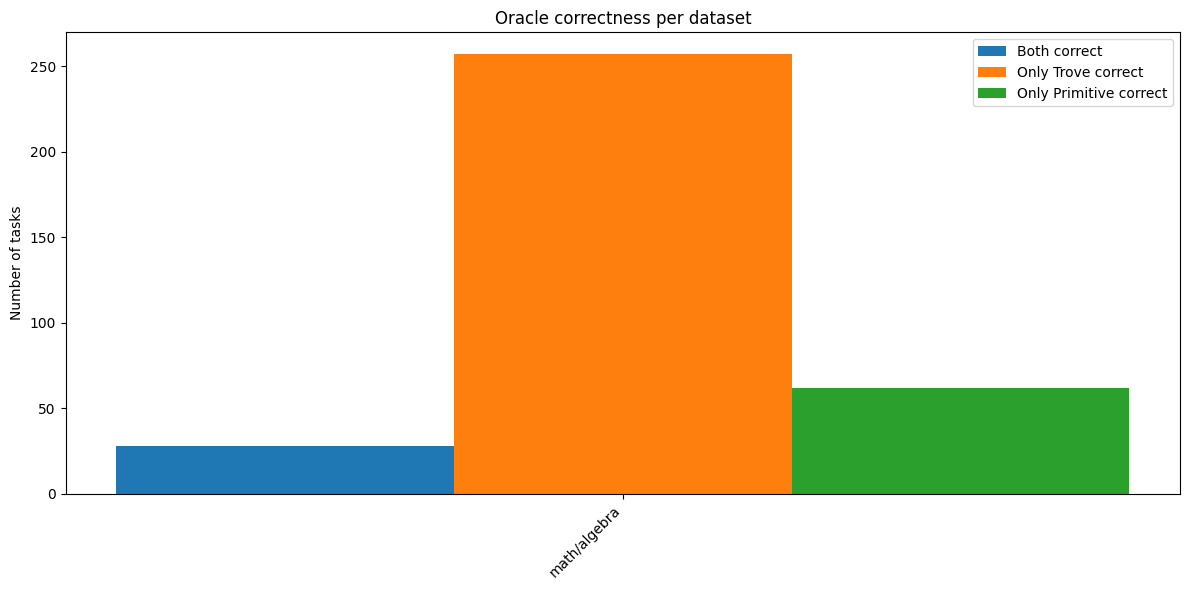

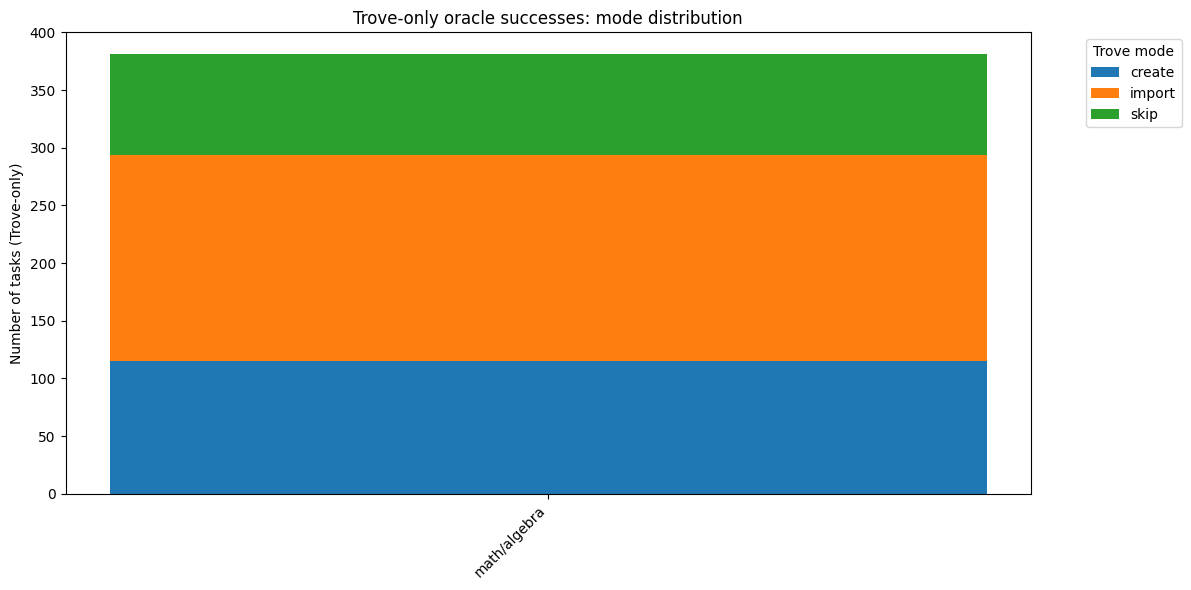

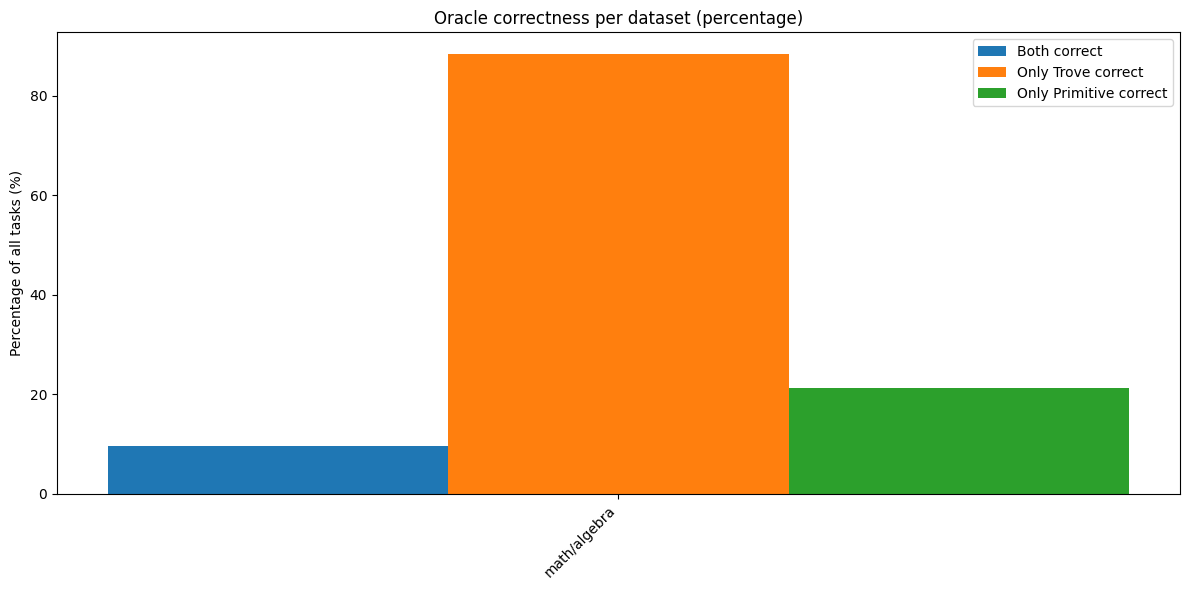

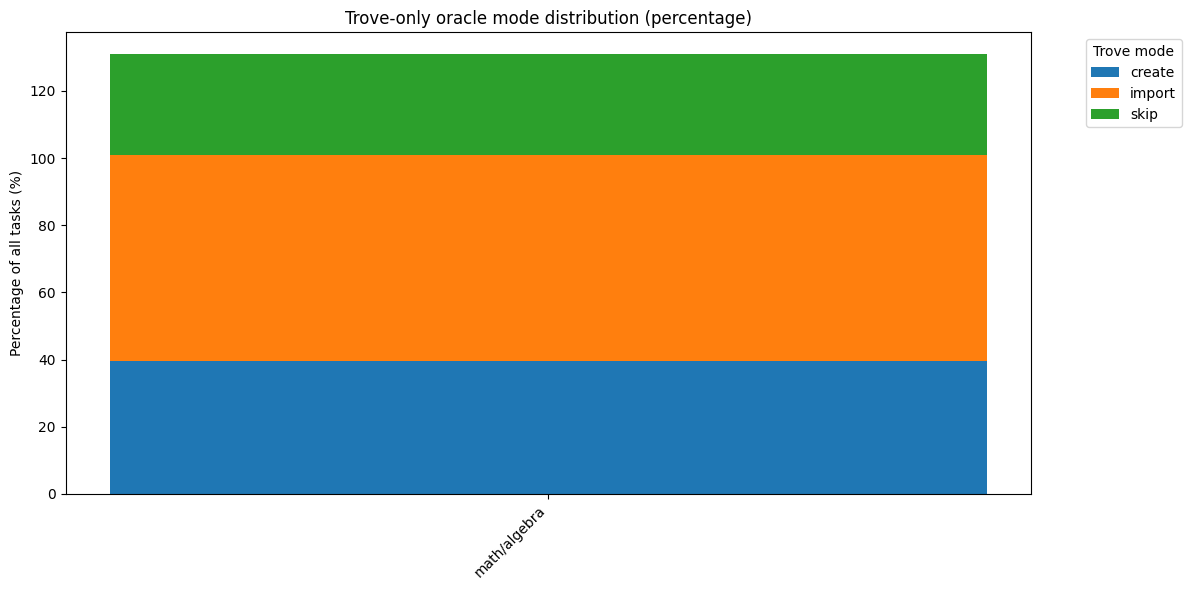

In [8]:
"""
oracle_plots.py – Plots for PRIMITIVE-Oracle vs TROVE-Oracle (import/create/skip)

• Fig 1  – grouped bars:   both-correct / Trove-only / Primitive-only
• Fig 2  – stacked bars:   Trove-only successes, broken down by mode
• Fig 3  – same as Fig 1 but as % of *all* tasks in the data-set
• Fig 4  – same as Fig 2 but as % of *all* tasks in the data-set
"""
# ── 0. Imports ────────────────────────────────────────────────────────────────
from pathlib import Path
from collections import Counter
import re
import json                    # only used for dataset-size sanity check
import numpy as np
import matplotlib.pyplot as plt



# ── 2. Tiny Markdown helper functions ─────────────────────────────────────────
EX_BLOCK  = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S | re.I)
CORRECT   = re.compile(r"Is Answer Correct:\s*True", re.I)

def all_example_ids(md_path: str | Path):
    "Return *every* Example-index that appears in a file (duplicates kept)."
    text = Path(md_path).read_text(encoding="utf-8")
    return [int(m.group(1)) for m in EX_BLOCK.finditer(text)]

def primitive_oracle_solved(md_path: str | Path):
    "Set of examples solved by *Primitive* oracle."
    text = Path(md_path).read_text(encoding="utf-8")
    return {int(ex) for ex, block in EX_BLOCK.findall(text) if CORRECT.search(block)}

def trove_oracle_solved_by_mode(md_path: str | Path):
    """
    Parse a Trove-Oracle .md file where each example ‘k’ occurs three times,
    always in the order:  create  →  import  →  skip.

    Returns  { 'create': {…}, 'import': {…}, 'skip': {…} }   sets of example IDs
    that the *given mode* solved (i.e. has “Is Answer Correct: True” in its
    own block).
    """
    ORDER = ("create", "import", "skip")           # positional mapping
    seen_count: dict[int, int] = {}                # example → how many blocks seen

    solved = {m: set() for m in ORDER}

    text = Path(md_path).read_text(encoding="utf-8")
    for ex_str, block in EX_BLOCK.findall(text):
        ex_id = int(ex_str)
        idx   = seen_count.get(ex_id, 0)           # 0, 1, 2
        if idx >= 3:                               # safeguard: ignore any extras
            raise ValueError(f"Example {ex_id} has too many blocks in {md_path}")
        mode  = ORDER[idx]
        seen_count[ex_id] = idx + 1                # bump counter

        if CORRECT.search(block):
            solved[mode].add(ex_id)

    return solved

# ── 3. Containers for plotting ────────────────────────────────────────────────
datasets                       = []
both_correct_counts            = []
only_trove_correct_counts      = []
only_primitive_correct_counts  = []

trove_mode_counters            = {}   # dataset → Counter
all_modes                      = set()

dataset_totals                 = []   # number of distinct tasks

# ── 4. Main loop over data-sets ───────────────────────────────────────────────
for ds in choices:
    if ds not in data_paths:
        print(f"[warning] {ds}: no paths given – skipped.")
        continue

    prim_md, trove_md = data_paths[ds]

    prim_ok         = primitive_oracle_solved(prim_md)
    trove_ok_by_mod = trove_oracle_solved_by_mode(trove_md)
    trove_ok        = set().union(*trove_ok_by_mod.values())

    both            = prim_ok & trove_ok
    only_trove      = trove_ok - prim_ok
    only_prim       = prim_ok - trove_ok

    # ─ fill plot containers ─
    datasets.append(ds)
    both_correct_counts.append(len(both))
    only_trove_correct_counts.append(len(only_trove))
    only_primitive_correct_counts.append(len(only_prim))

    mode_counter = Counter()
    for m, ex_set in trove_ok_by_mod.items():
        mode_counter[m] = len(ex_set & only_trove)   # count *only-trove* solves
    trove_mode_counters[ds] = mode_counter
    all_modes.update(mode_counter)

    # dataset total = #distinct example ids (Primitive file == Trove file)
    total = len(set(all_example_ids(prim_md)))
    dataset_totals.append(total)

# convert to numpy for vectorised maths later
dataset_totals = np.array(dataset_totals)

# ── 5. PLOT 1  – grouped bars: correctness counts ────────────────────────────
x          = np.arange(len(datasets))
bar_width  = 0.25

fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(x - bar_width, both_correct_counts,           width=bar_width, label="Both correct")
ax1.bar(x,            only_trove_correct_counts,      width=bar_width, label="Only Trove correct")
ax1.bar(x + bar_width, only_primitive_correct_counts, width=bar_width, label="Only Primitive correct")

ax1.set_xticks(x)
ax1.set_xticklabels(datasets, rotation=45, ha="right")
ax1.set_ylabel("Number of tasks")
ax1.set_title("Oracle correctness per dataset")
ax1.legend()
fig1.tight_layout()

# ── 6. PLOT 2  – stacked bars: Trove-only mode counts ────────────────────────
fig2, ax2 = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(datasets))

for mode in sorted(all_modes):
    counts = [trove_mode_counters[d].get(mode, 0) for d in datasets]
    ax2.bar(x, counts, bottom=bottom, label=mode)
    bottom += counts

ax2.set_xticks(x)
ax2.set_xticklabels(datasets, rotation=45, ha="right")
ax2.set_ylabel("Number of tasks (Trove-only)")
ax2.set_title("Trove-only oracle successes: mode distribution")
ax2.legend(title="Trove mode", bbox_to_anchor=(1.05, 1), loc="upper left")
fig2.tight_layout()

# ── 7. PLOT 3  – grouped bars as *percent* of all tasks ───────────────────────
percent_both      = 100 * np.array(both_correct_counts)          / dataset_totals
percent_trove     = 100 * np.array(only_trove_correct_counts)    / dataset_totals
percent_primitive = 100 * np.array(only_primitive_correct_counts)/ dataset_totals

fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.bar(x - bar_width, percent_both,      width=bar_width, label="Both correct")
ax3.bar(x,            percent_trove,     width=bar_width, label="Only Trove correct")
ax3.bar(x + bar_width, percent_primitive, width=bar_width, label="Only Primitive correct")

ax3.set_xticks(x)
ax3.set_xticklabels(datasets, rotation=45, ha="right")
ax3.set_ylabel("Percentage of all tasks (%)")
ax3.set_title("Oracle correctness per dataset (percentage)")
ax3.legend()
fig3.tight_layout()

# ── 8. PLOT 4  – Trove-only mode percentages ─────────────────────────────────
fig4, ax4 = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(datasets))

for mode in sorted(all_modes):
    counts = np.array([trove_mode_counters[d].get(mode, 0) for d in datasets])
    perc   = 100 * counts / dataset_totals
    ax4.bar(x, perc, bottom=bottom, label=mode)
    bottom += perc

ax4.set_xticks(x)
ax4.set_xticklabels(datasets, rotation=45, ha="right")
ax4.set_ylabel("Percentage of all tasks (%)")
ax4.set_title("Trove-only oracle mode distribution (percentage)")
ax4.legend(title="Trove mode", bbox_to_anchor=(1.05, 1), loc="upper left")
fig4.tight_layout()

plt.show()

# Comparison

We compare oracle and normal.

## Old

This is old stuff, we only have it here because it had the print statements.


=== MATH/ALGEBRA ===
PRIM vs TROVE       normal  oracle   Δ
Both               132     220    88
Trove Only          90      65   -25
Prim Only          100     162    62
TROVE total solved:    222 → 285     Δ +63
PRIM  total solved:    232 → 382     Δ +150

=== MATH/COUNTING ===
PRIM vs TROVE       normal  oracle   Δ
Both                43      93    50
Trove Only          21      34    13
Prim Only           23      38    15
TROVE total solved:     64 → 127     Δ +63
PRIM  total solved:     66 → 131     Δ +65

=== MATH/GEOMETRY ===
PRIM vs TROVE       normal  oracle   Δ
Both                 2      34    32
Trove Only          13      28    15
Prim Only           20      37    17
TROVE total solved:     15 → 62      Δ +47
PRIM  total solved:     22 → 71      Δ +49

=== MATH/INTERMEDIATE ===
PRIM vs TROVE       normal  oracle   Δ
Both                19      77    58
Trove Only          37      58    21
Prim Only           39      45     6
TROVE total solved:     56 → 135     Δ +79
PRI

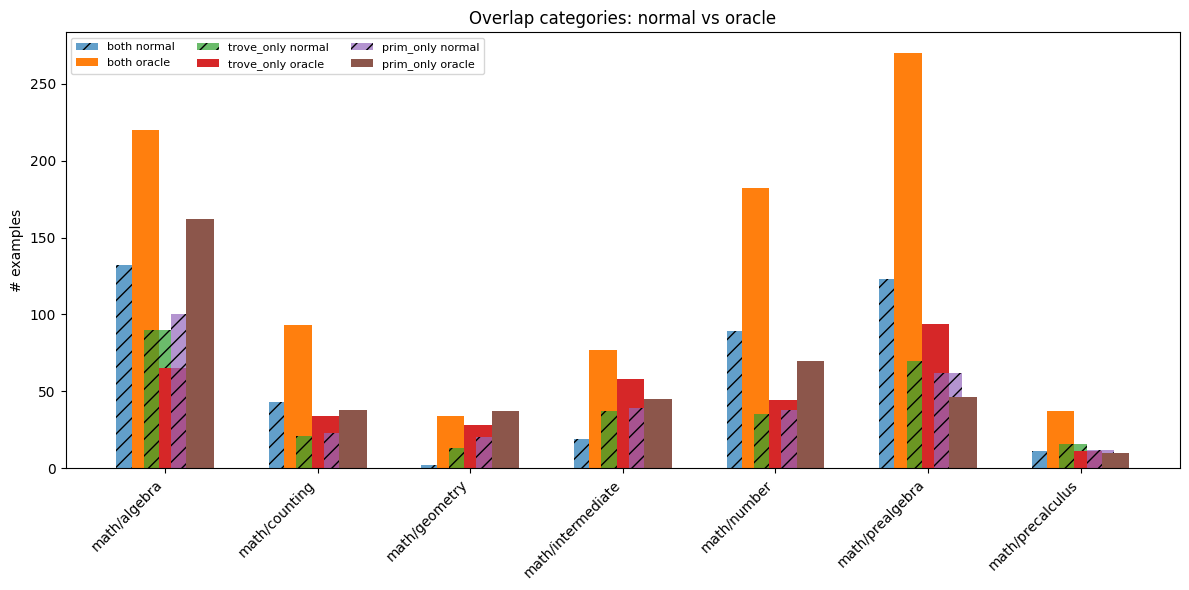

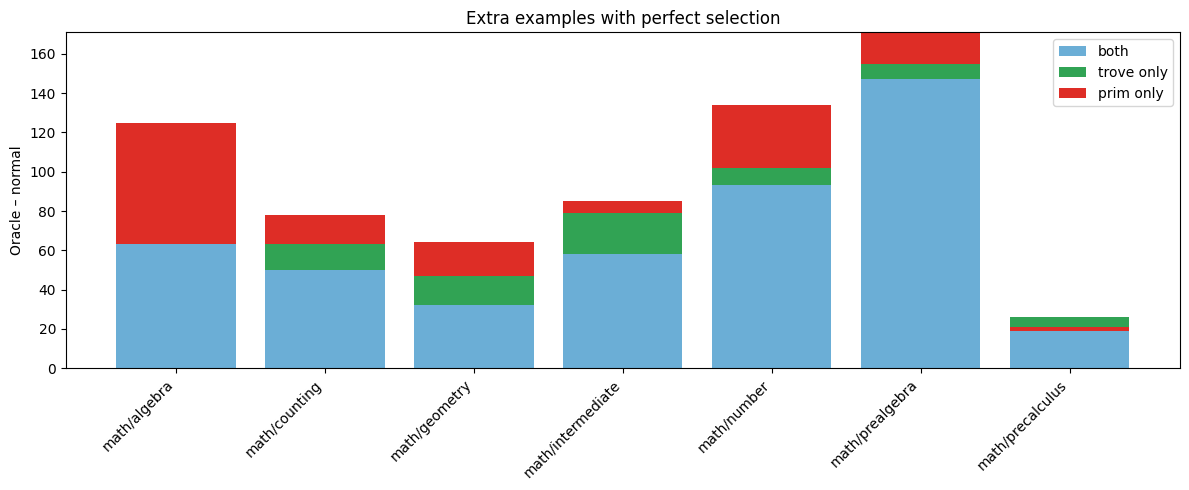

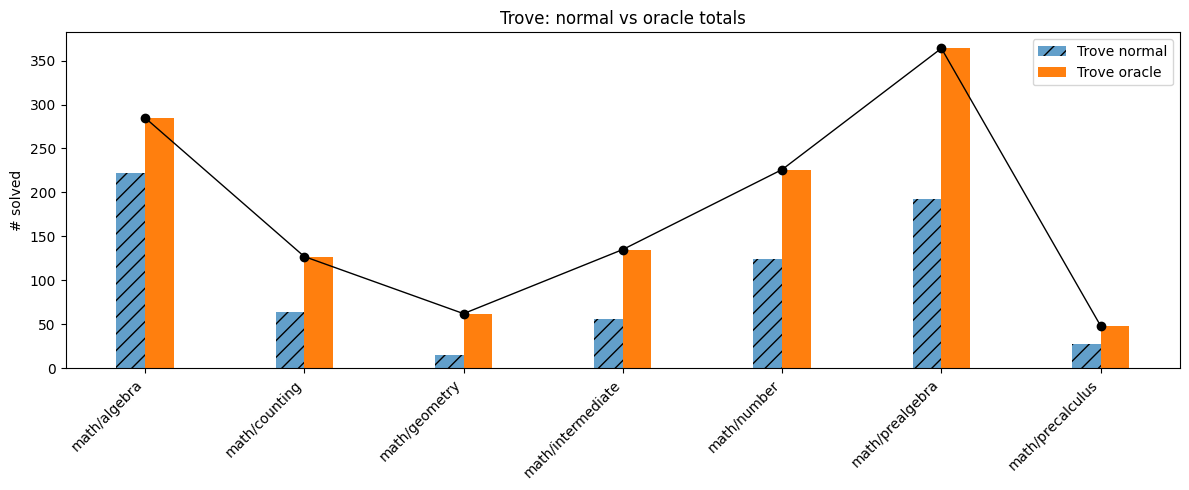

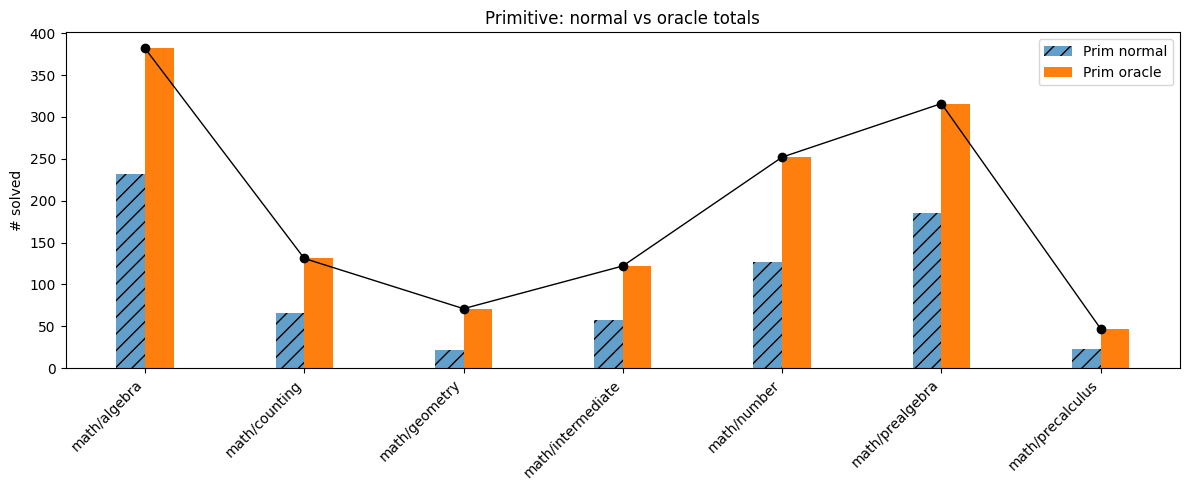

In [16]:
#!/usr/bin/env python
"""
Compare *normal* results (single selected attempt in JSON) with *oracle*
results (all attempts in Markdown) for  Primitive  vs  Trove.

Figures:
    • Fig 1 – grouped bars (normal vs oracle) for each overlap category
    • Fig 2 – bars of delta values  (oracle – normal)
"""
# ── 0. Imports ────────────────────────────────────────────────────────────────
import json, re
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# ── 1. DATA-SET PATHS  --------------------------------------------------------
choices = [
    "math/algebra", "math/counting", "math/geometry",
    "math/intermediate", "math/number",
    "math/prealgebra", "math/precalculus",
    # "tabmwp", "wtq", "hitab", "gqa"
]

#   value = [primitive_normal.json, trove_normal.json]
json_paths: Dict[str, List[str]] = {}
json_paths["math/algebra"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/results/Noneex/primitive/run20250211162307.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/results/Noneex/trove/run2.json"
]

json_paths["math/counting"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/results/Noneex/primitive/run20250211155451.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/results/Noneex/trove/run20250206124947.json"
]

json_paths["math/geometry"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/results/Noneex/primitive/run20250211155050.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/results/Noneex/trove/run20250212003727.json"
]

json_paths["math/intermediate"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/results/Noneex/primitive/run20250212035420.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/results/Noneex/trove/run20250212060318.json"
]

json_paths["math/number"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/results/Noneex/primitive/run20250211183137.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/results/Noneex/trove/run20250212023156.json"
]

json_paths["math/prealgebra"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/results/Noneex/primitive/run20250211205325.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/results/Noneex/trove/run20250212023740.json"
]

json_paths["math/precalculus"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/results/Noneex/primitive/run20250211140654.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/results/Noneex/trove/run20250212031007.json"
]

md_paths: Dict[str, List[str]] = {
    "math/algebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/primitive/run20250211162307_2025-02-11-16-23-07.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run2.md",
    ],
    "math/counting": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211155451_2025-02-11-15-54-51.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md"
    ],
    "math/geometry": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155050_2025-02-11-15-50-50.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md"
    ],
    "math/intermediate": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/primitive/run20250212035420_2025-02-12-03-54-20.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/trove/run20250212060318_2025-02-12-06-03-18.md"
    ],
    "math/number": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/primitive/run20250211183137_2025-02-11-18-31-37.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/trove/run20250212023156_2025-02-12-02-31-56.md"
    ],
    "math/prealgebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/primitive/run20250211205325_2025-02-11-20-53-25.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/trove/run20250212023740_2025-02-12-02-37-40.md"
    ],
    "math/precalculus": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/primitive/run20250211140654_2025-02-11-14-06-54.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/trove/run20250212031007_2025-02-12-03-10-07.md"
    ],
}

# ── 2. Helpers for Markdown  --------------------------------------------------
EX = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S|re.I)
OK = re.compile(r"Is Answer Correct:\s*True", re.I)
def md_solved(p: str|Path)->Set[int]:
    txt=Path(p).read_text('utf-8');return{int(i)for i,b in EX.findall(txt)if OK.search(b)}

# ── 3. Containers -------------------------------------------------------------
overlap_cats = ("both","trove_only","prim_only")
norm_cnt, orc_cnt, d_cnt  = defaultdict(list), defaultdict(list), defaultdict(list)
trove_tot_norm = []; trove_tot_orc = []; prim_tot_norm = []; prim_tot_orc = []
ds_labels      = []

# ── 4. Main loop --------------------------------------------------------------
for ds in choices:
    if ds not in json_paths or ds not in md_paths:
        print(f"[warn] {ds} paths missing – skipped."); continue

    # ---- read files ----
    j_prim, j_tr = json_paths[ds];  m_prim, m_tr = md_paths[ds]
    prim_json   = json.loads(Path(j_prim).read_text())
    trove_json  = json.loads(Path(j_tr ).read_text())
    prim_norm   = {i for i,e in enumerate(prim_json) if e["is_correct"]}
    trove_norm  = {i for i,e in enumerate(trove_json) if e["response"]["is_correct"]}
    prim_orc    = md_solved(m_prim)
    trove_orc   = md_solved(m_tr)

    # ---- overlap counts normal vs oracle (old logic) ----
    def cnt(a:Set[int],b:Set[int])->Tuple[int,int,int]:
        return len(a&b), len(b-a), len(a-b)
    c_norm, c_orc = cnt(prim_norm,trove_norm), cnt(prim_orc,trove_orc)
    d             = tuple(o-n for o,n in zip(c_orc,c_norm))

    # ---- print main overlap table ----
    print(f"\n=== {ds.upper()} ===")
    print("PRIM vs TROVE       normal  oracle   Δ")
    for cat,n,o,dd in zip(overlap_cats,c_norm,c_orc,d):
        print(f"{cat.replace('_',' ').title():<15}{n:>7}{o:>8}{dd:>6}")

    # ---- Trove-only comparison ----
    t_norm, t_orc = len(trove_norm), len(trove_orc)
    print(f"TROVE total solved: {t_norm:>6} → {t_orc:<6}  Δ {t_orc-t_norm:+}")
    # ---- Primitive-only comparison ----
    p_norm, p_orc = len(prim_norm), len(prim_orc)
    print(f"PRIM  total solved: {p_norm:>6} → {p_orc:<6}  Δ {p_orc-p_norm:+}")

    # ---- store for plots ----
    ds_labels.append(ds)
    for cat,n,o,dd in zip(overlap_cats,c_norm,c_orc,d):
        norm_cnt[cat].append(n); orc_cnt[cat].append(o); d_cnt[cat].append(dd)
    trove_tot_norm.append(t_norm); trove_tot_orc.append(t_orc)
    prim_tot_norm.append(p_norm);  prim_tot_orc.append(p_orc)

# ── 5. PLOTS ------------------------------------------------------------------
x=np.arange(len(ds_labels)); w=0.18; off=(-w,0,w)

# -- Fig1 grouped bars overlap --------------------------------------------------
fig1,ax1=plt.subplots(figsize=(12,6))
for i,cat in enumerate(overlap_cats):
    ax1.bar(x+off[i]-0.05,norm_cnt[cat],w,label=f"{cat} normal",hatch='//',alpha=.7)
    ax1.bar(x+off[i]+0.05,orc_cnt[cat],w,label=f"{cat} oracle")
ax1.set_xticks(x);ax1.set_xticklabels(ds_labels,rotation=45,ha="right")
ax1.set_ylabel("# examples");ax1.set_title("Overlap categories: normal vs oracle")
ax1.legend(ncol=3,fontsize=8);fig1.tight_layout()

# -- Fig2 delta stacked --------------------------------------------------------
fig2,ax2=plt.subplots(figsize=(12,5))
bottom=np.zeros(len(ds_labels))
cols={"both":"#6baed6","trove_only":"#31a354","prim_only":"#de2d26"}
for cat in overlap_cats:
    ax2.bar(x,d_cnt[cat],bottom=bottom,label=cat.replace('_',' '),color=cols[cat])
    bottom+=d_cnt[cat]
ax2.set_xticks(x);ax2.set_xticklabels(ds_labels,rotation=45,ha="right")
ax2.set_ylabel("Oracle – normal");ax2.set_title("Extra examples with perfect selection")
ax2.legend();fig2.tight_layout()

# -- Fig3 Trove totals ---------------------------------------------------------
fig3,ax3=plt.subplots(figsize=(12,5))
ax3.bar(x-w/2,trove_tot_norm,width=w,label="Trove normal",hatch='//',alpha=.7)
ax3.bar(x+w/2,trove_tot_orc ,width=w,label="Trove oracle")
ax3.plot(x,trove_tot_orc,marker='o',color='k',linewidth=1)
ax3.set_xticks(x);ax3.set_xticklabels(ds_labels,rotation=45,ha="right")
ax3.set_ylabel("# solved");ax3.set_title("Trove: normal vs oracle totals")
ax3.legend();fig3.tight_layout()

# -- Fig4 Primitive totals -----------------------------------------------------
fig4,ax4=plt.subplots(figsize=(12,5))
ax4.bar(x-w/2,prim_tot_norm,width=w,label="Prim normal",hatch='//',alpha=.7)
ax4.bar(x+w/2,prim_tot_orc ,width=w,label="Prim oracle")
ax4.plot(x,prim_tot_orc,marker='o',color='k',linewidth=1)
ax4.set_xticks(x);ax4.set_xticklabels(ds_labels,rotation=45,ha="right")
ax4.set_ylabel("# solved");ax4.set_title("Primitive: normal vs oracle totals")
ax4.legend();fig4.tight_layout()

plt.show()

## New Stuff

[cache] Building data … this may take a while
[cache] Data cached to 'oracle_cache.pkl'


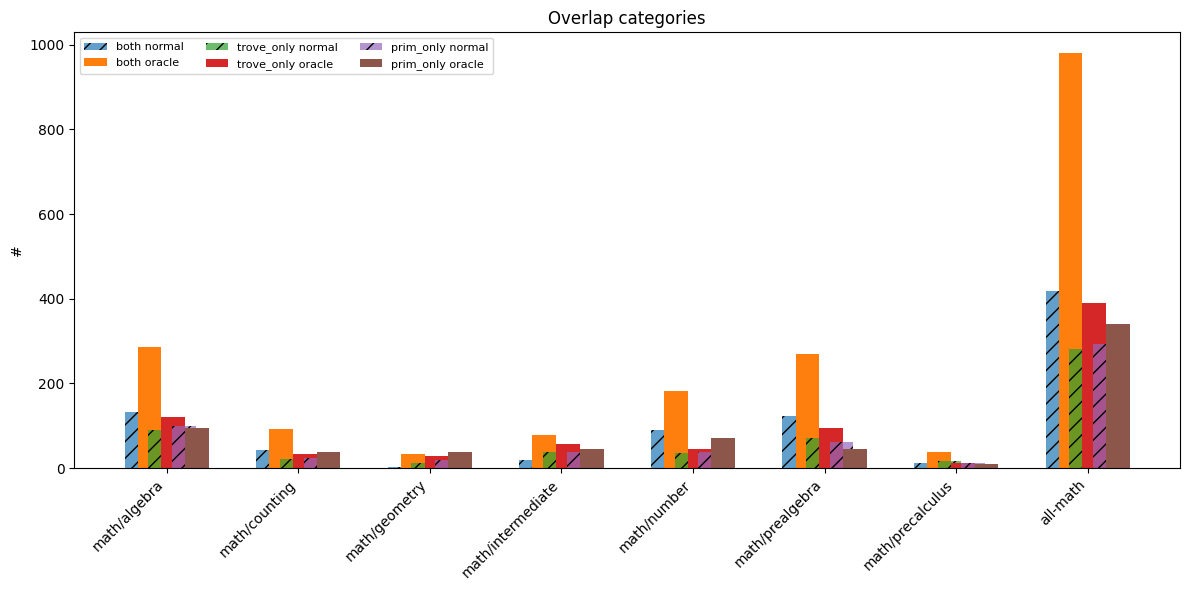

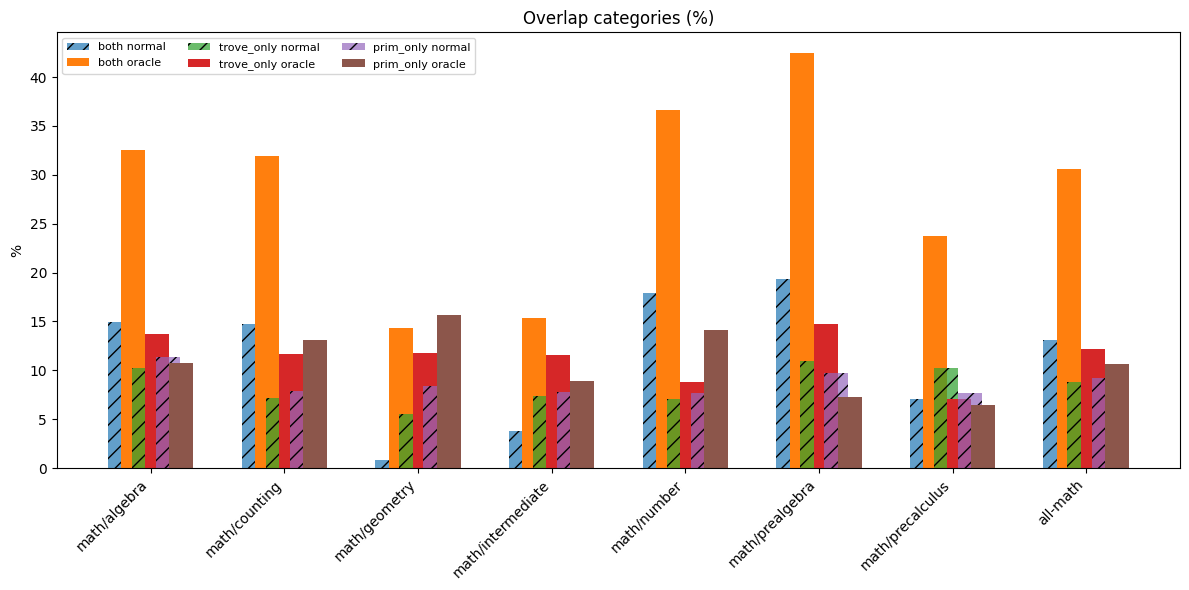

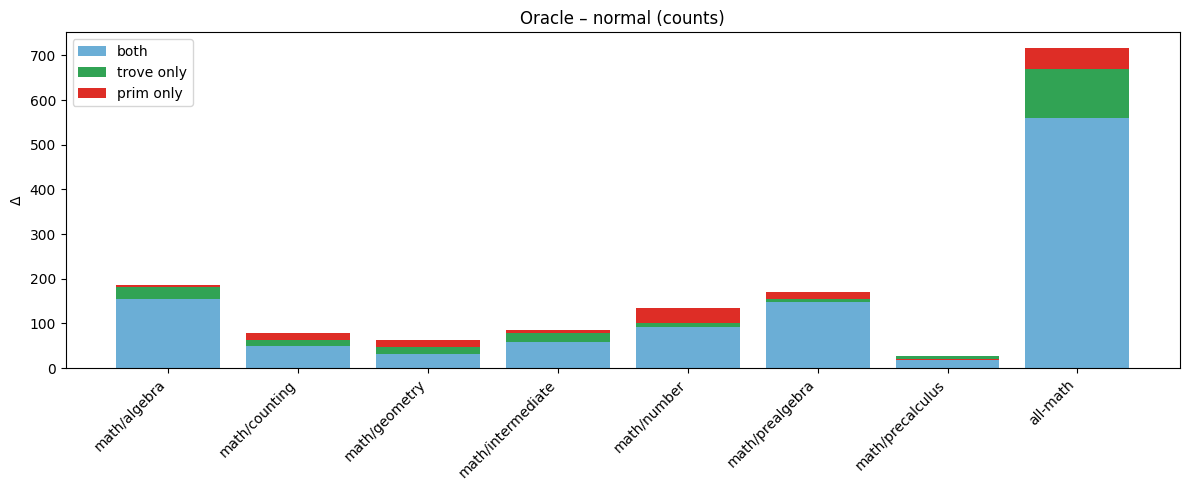

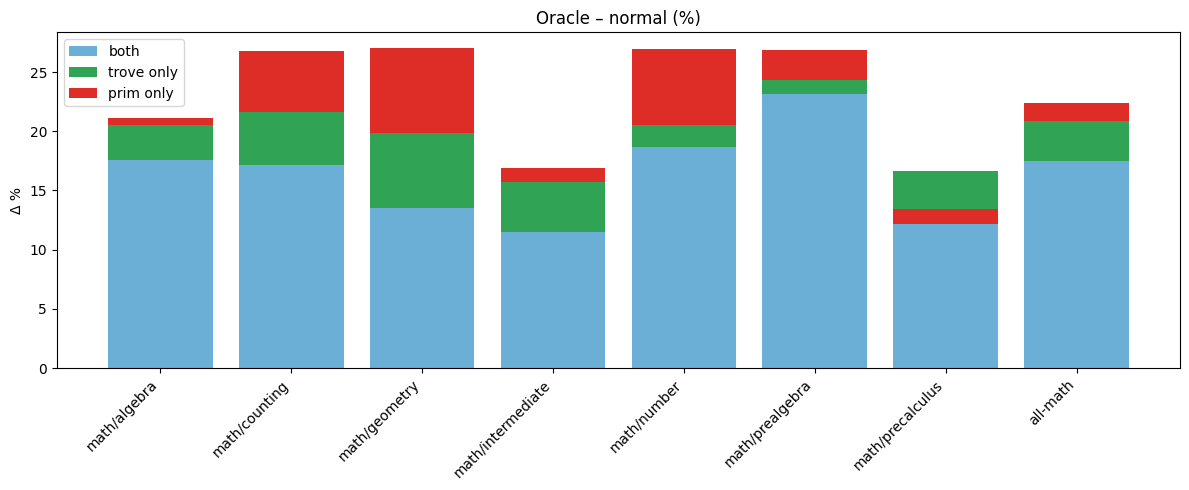

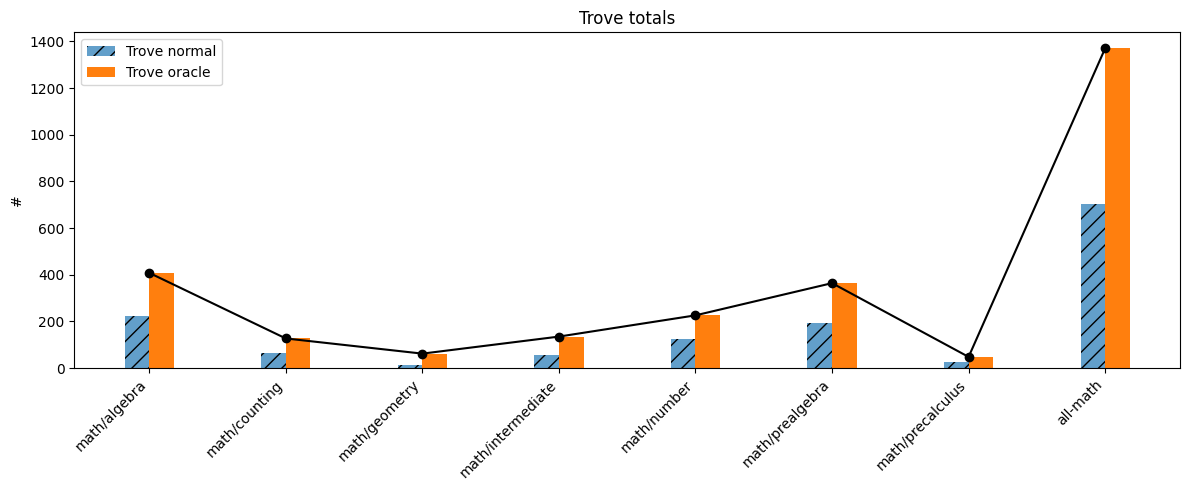

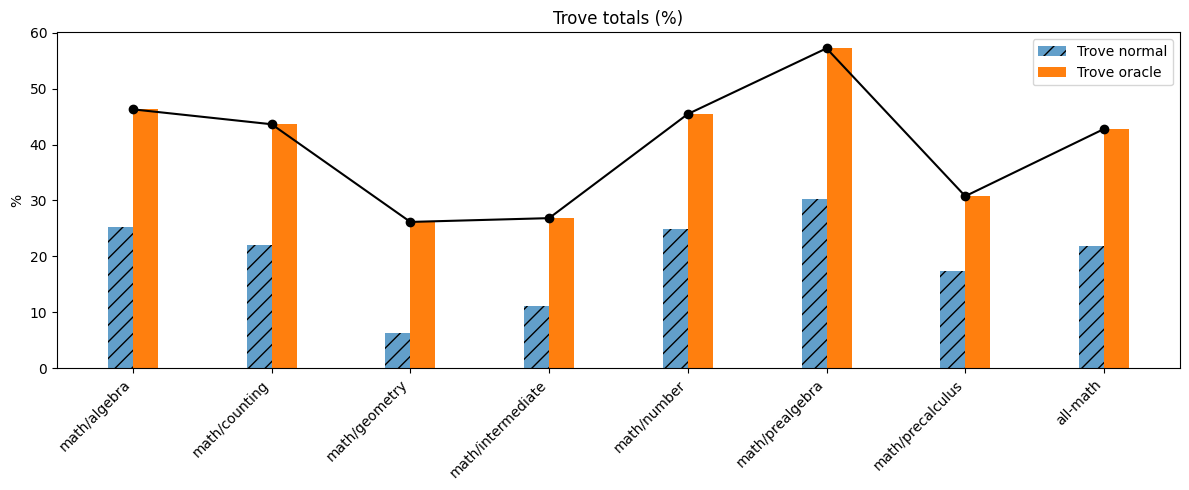

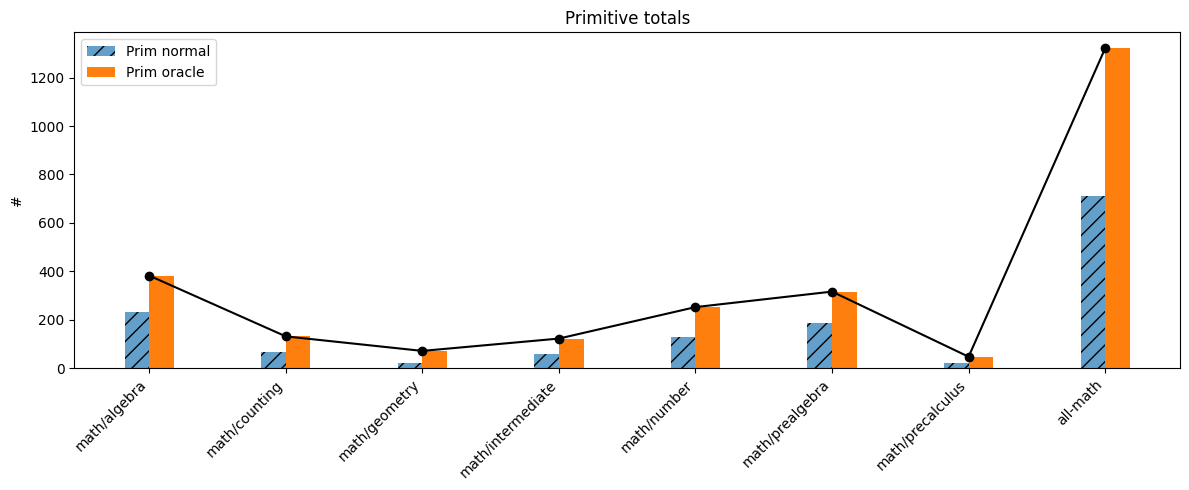

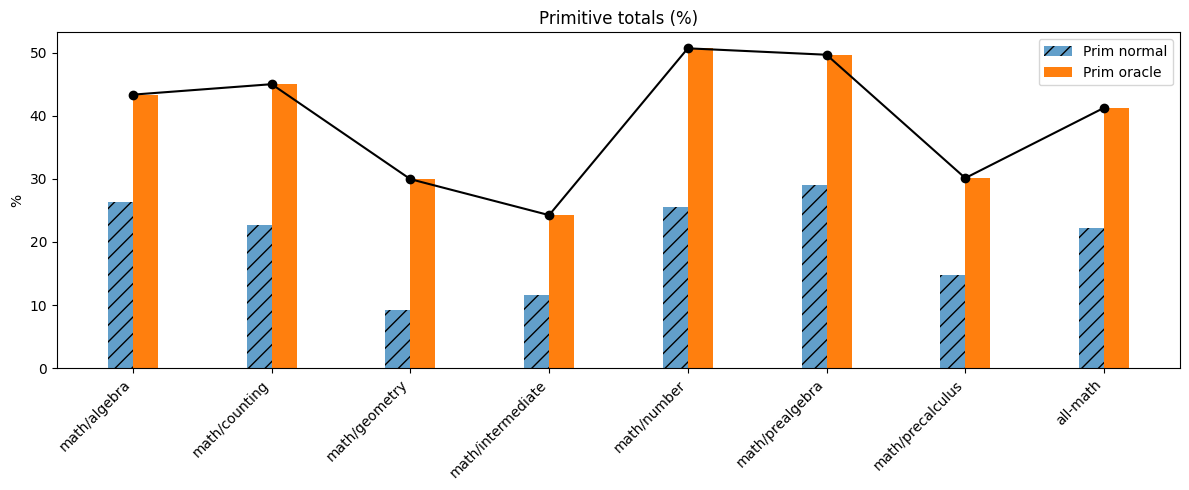

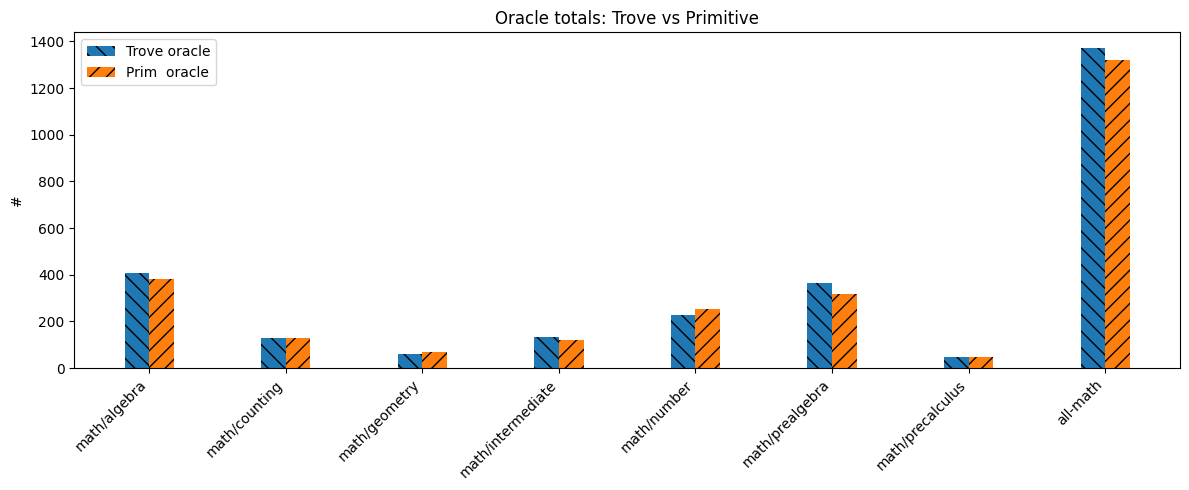

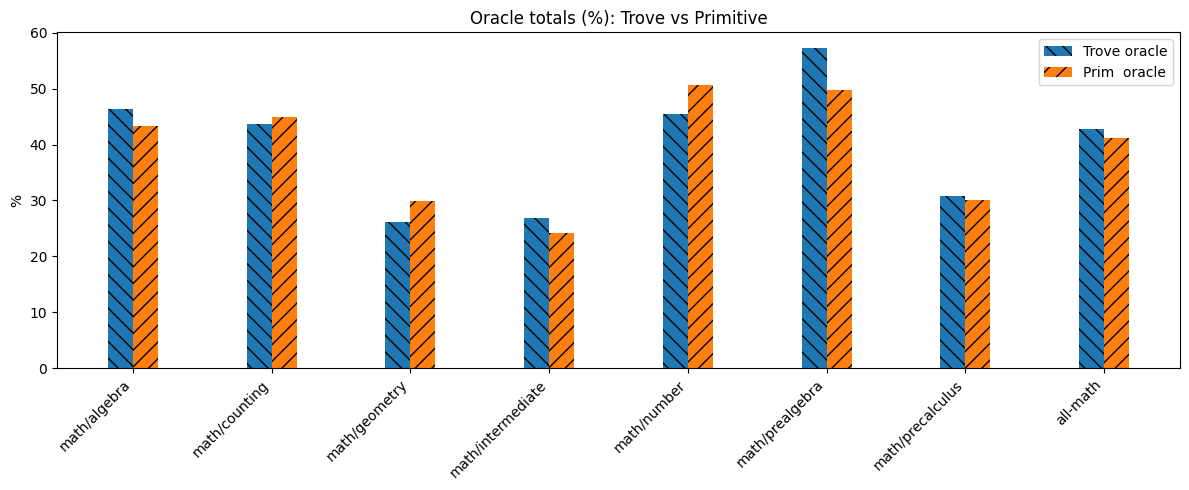

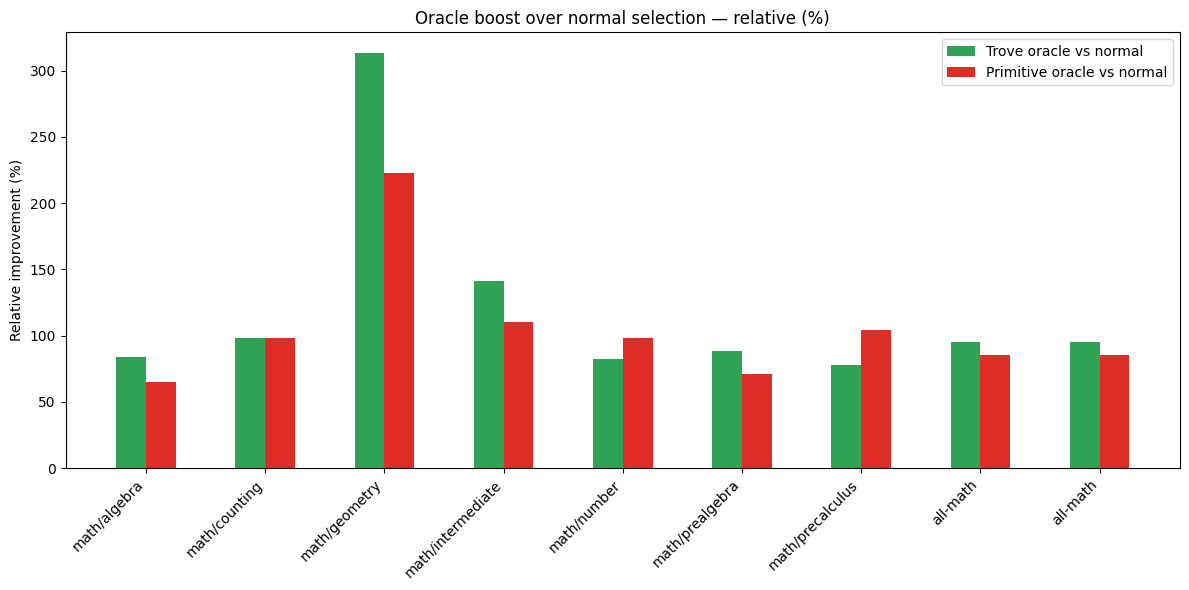

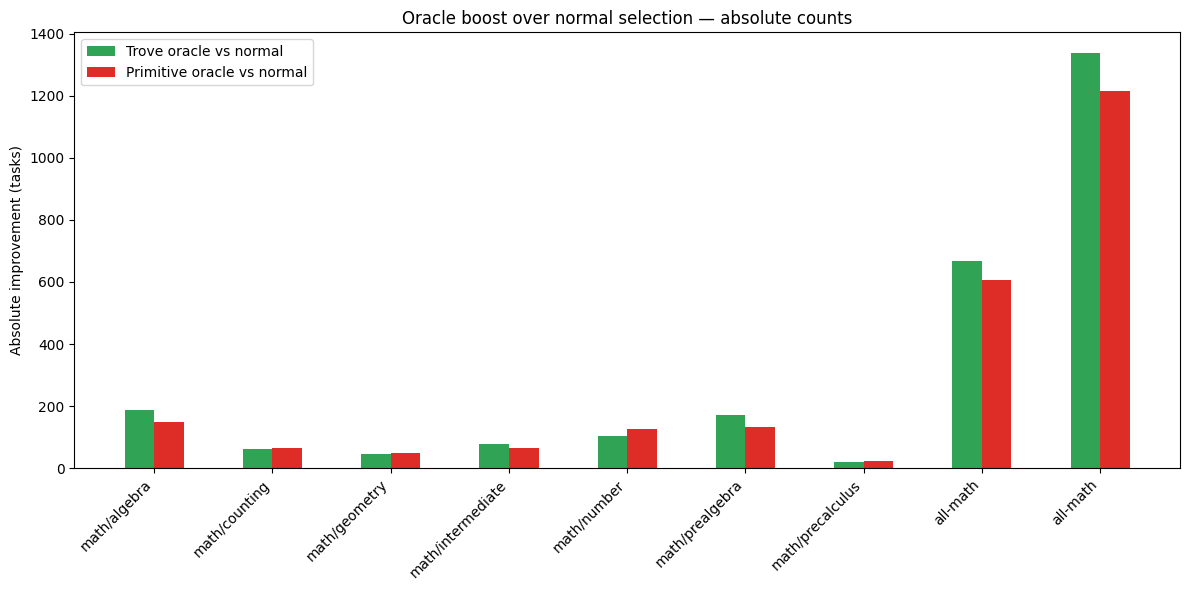

In [5]:
"""
Primitive & Trove  –  normal-run JSON  vs  oracle-run Markdown

If 'oracle_cache.pkl' is present, we reuse the parsed counts instead of
re-reading every file.  Delete the file (or set FORCE_REBUILD = True) whenever
you want to refresh the data.
"""
# ── Imports ───────────────────────────────────────────────────────────────────
import json, re, pickle, os
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# ── Config ────────────────────────────────────────────────────────────────────
FORCE_REBUILD = True                 # set True to ignore / overwrite cache
CACHE_FILE    = "oracle_cache.pkl"    # relative path is fine

# ── 1. DATA-SET PATHS  --------------------------------------------------------
choices = [
    "math/algebra", "math/counting", "math/geometry",
    "math/intermediate", "math/number",
    "math/prealgebra", "math/precalculus",
    # "tabmwp", "wtq", "hitab", "gqa"
]

#   value = [primitive_normal.json, trove_normal.json]
json_paths: Dict[str, List[str]] = {}
json_paths["math/algebra"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/results/Noneex/primitive/run20250211162307.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/results/Noneex/trove/run2.json"
]

json_paths["math/counting"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/results/Noneex/primitive/run20250211155451.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/results/Noneex/trove/run20250206124947.json"
]

json_paths["math/geometry"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/results/Noneex/primitive/run20250211155050.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/results/Noneex/trove/run20250212003727.json"
]

json_paths["math/intermediate"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/results/Noneex/primitive/run20250212035420.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/results/Noneex/trove/run20250212060318.json"
]

json_paths["math/number"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/results/Noneex/primitive/run20250211183137.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/results/Noneex/trove/run20250212023156.json"
]

json_paths["math/prealgebra"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/results/Noneex/primitive/run20250211205325.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/results/Noneex/trove/run20250212023740.json"
]

json_paths["math/precalculus"] = [
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/results/Noneex/primitive/run20250211140654.json",
    "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/results/Noneex/trove/run20250212031007.json"
]

md_paths: Dict[str, List[str]] = {
    "math/algebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/primitive/run20250211162307_2025-02-11-16-23-07.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/algebra/log/Noneex/trove/run20250211225721_2025-02-11-22-57-21.md",
    ],
    "math/counting": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/primitive/run20250211155451_2025-02-11-15-54-51.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/counting/log/Noneex/trove/run20250206124947_2025-02-06-12-49-47.md"
    ],
    "math/geometry": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/primitive/run20250211155050_2025-02-11-15-50-50.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/geometry/log/Noneex/trove/run20250212003727_2025-02-12-00-37-27.md"
    ],
    "math/intermediate": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/primitive/run20250212035420_2025-02-12-03-54-20.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/intermediate/log/Noneex/trove/run20250212060318_2025-02-12-06-03-18.md"
    ],
    "math/number": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/primitive/run20250211183137_2025-02-11-18-31-37.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/number/log/Noneex/trove/run20250212023156_2025-02-12-02-31-56.md"
    ],
    "math/prealgebra": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/primitive/run20250211205325_2025-02-11-20-53-25.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/prealgebra/log/Noneex/trove/run20250212023740_2025-02-12-02-37-40.md"
    ],
    "math/precalculus": [
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/primitive/run20250211140654_2025-02-11-14-06-54.md",
        "/ceph/tsesterh/abstraction/trove/output_codellama/CodeLlama-7b-Instruct-hf/math/precalculus/log/Noneex/trove/run20250212031007_2025-02-12-03-10-07.md"
    ],
}
#json_paths: Dict[str, List[str]] = { … }   # [primitive.json, trove.json]
#md_paths:   Dict[str, List[str]] = { … }   # [primitive_orc.md, trove_orc.md]

# ── Markdown helper ───────────────────────────────────────────────────────────
EX = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S|re.I)
OK = re.compile(r"Is Answer Correct:\s*True", re.I)
def md_solved(p): txt=Path(p).read_text('utf-8');return{int(i)for i,b in EX.findall(txt) if OK.search(b)}

# ── Try to load cache ────────────────────────────────────────────────────────
if not FORCE_REBUILD and os.path.exists(CACHE_FILE):
    print(f"[cache] Loading data from {CACHE_FILE!r}")
    with open(CACHE_FILE, "rb") as fh:
        (norm_cnt, orc_cnt, d_cnt,
         trove_n, trove_o, prim_n, prim_o,
         totals, ds_labels) = pickle.load(fh)
else:
    print("[cache] Building data … this may take a while")
    # containers
    cats = ("both","trove_only","prim_only")
    norm_cnt=defaultdict(list); orc_cnt=defaultdict(list); d_cnt=defaultdict(list)
    trove_n=[]; trove_o=[]; prim_n=[]; prim_o=[]; totals=[]; ds_labels=[]

    # main loop
    for ds in choices:
        if ds not in json_paths or ds not in md_paths: continue
        pj,tj = map(Path, json_paths[ds]); mp,mt = map(Path, md_paths[ds])
        pj,pn = json.loads(pj.read_text()), set()
        tj,tn = json.loads(tj.read_text()), set()
        pn={i for i,e in enumerate(pj) if e["is_correct"]}
        tn={i for i,e in enumerate(tj) if e["response"]["is_correct"]}
        po, to = md_solved(mp), md_solved(mt)

        def cnt(a:Set[int],b:Set[int])->Tuple[int,int,int]:
            return len(a&b), len(b-a), len(a-b)
        c_n,c_o=cnt(pn,tn),cnt(po,to); d=tuple(o-n for o,n in zip(c_o,c_n))

        ds_labels.append(ds)
        for cat,n,o,dd in zip(cats,c_n,c_o,d):
            norm_cnt[cat].append(n); orc_cnt[cat].append(o); d_cnt[cat].append(dd)
        trove_n.append(len(tn)); trove_o.append(len(to))
        prim_n.append(len(pn));  prim_o.append(len(po))
        totals.append(len(pj))

    # save cache
    with open(CACHE_FILE, "wb") as fh:
        pickle.dump((norm_cnt,orc_cnt,d_cnt,
                     trove_n,trove_o,prim_n,prim_o,
                     totals,ds_labels), fh)
    print(f"[cache] Data cached to {CACHE_FILE!r}")

# 1. aggregated (all-math) numbers
all_tot_tasks  = sum(totals)
all_prim_n     = sum(prim_n)
all_prim_o     = sum(prim_o)
all_trove_n    = sum(trove_n)
all_trove_o    = sum(trove_o)

# 2. append to every per-domain list
ds_labels.append("all-math")
totals  .append(all_tot_tasks)

prim_n  .append(all_prim_n)
prim_o  .append(all_prim_o)
trove_n .append(all_trove_n)
trove_o .append(all_trove_o)

abs_prim  = list(np.array(prim_o)  - np.array(prim_n))    # will be reused later
abs_trove = list(np.array(trove_o) - np.array(trove_n))

for cat in ("both", "trove_only", "prim_only"):
    norm_cnt[cat].append(sum(norm_cnt[cat]))
    orc_cnt [cat].append(sum(orc_cnt [cat]))
    d_cnt   [cat].append(sum(d_cnt   [cat]))

# 3. rebuild x-positions now that we have one extra column
x   = np.arange(len(ds_labels))        # len == original + 1
w   = 0.18
off = (-w, 0, w)



# ── Plotting section (unchanged) ──────────────────────────────────────────────
totals=np.array(totals,dtype=float); x=np.arange(len(ds_labels)); w=.18; off=(-w,0,w)
def pct(arr): return 100*np.array(arr)/totals
cats=("both","trove_only","prim_only")
cols={"both":"#6baed6","trove_only":"#31a354","prim_only":"#de2d26"}

# -- Fig 1 counts
fig1,ax1=plt.subplots(figsize=(12,6))
for i,cat in enumerate(cats):
    ax1.bar(x+off[i]-0.05,norm_cnt[cat],w,label=f"{cat} normal",hatch='//',alpha=.7)
    ax1.bar(x+off[i]+0.05,orc_cnt[cat],w,label=f"{cat} oracle")
ax1.set_xticks(x);ax1.set_xticklabels(ds_labels,rotation=45,ha="right")
ax1.set_title("Overlap categories");ax1.set_ylabel("#");ax1.legend(ncol=3,fontsize=8)
fig1.tight_layout()

# -- Fig 1b percentages
fig1b,ax1b=plt.subplots(figsize=(12,6))
for i,cat in enumerate(cats):
    ax1b.bar(x+off[i]-0.05,pct(norm_cnt[cat]),w,label=f"{cat} normal",hatch='//',alpha=.7)
    ax1b.bar(x+off[i]+0.05,pct(orc_cnt[cat]),w,label=f"{cat} oracle")
ax1b.set_xticks(x);ax1b.set_xticklabels(ds_labels,rotation=45,ha="right")
ax1b.set_title("Overlap categories (%)");ax1b.set_ylabel("%");ax1b.legend(ncol=3,fontsize=8)
fig1b.tight_layout()

# -- Fig 2 delta counts
fig2,ax2=plt.subplots(figsize=(12,5));bottom=np.zeros(len(x))
for cat in cats:
    ax2.bar(x,d_cnt[cat],bottom=bottom,label=cat.replace('_',' '),color=cols[cat])
    bottom+=d_cnt[cat]
ax2.set_xticks(x);ax2.set_xticklabels(ds_labels,rotation=45,ha="right")
ax2.set_title("Oracle – normal (counts)");ax2.set_ylabel("Δ");ax2.legend();fig2.tight_layout()

# -- Fig 2b delta %
fig2b,ax2b=plt.subplots(figsize=(12,5));bottom=np.zeros(len(x))
for cat in cats:
    arr=pct(d_cnt[cat]); ax2b.bar(x,arr,bottom=bottom,label=cat.replace('_',' '),color=cols[cat])
    bottom+=arr
ax2b.set_xticks(x);ax2b.set_xticklabels(ds_labels,rotation=45,ha="right")
ax2b.set_title("Oracle – normal (%)");ax2b.set_ylabel("Δ %");ax2b.legend();fig2b.tight_layout()

# -- Fig 3 Trove totals counts & %
trove_n=np.array(trove_n); trove_o=np.array(trove_o)
fig3,ax3=plt.subplots(figsize=(12,5))
ax3.bar(x-w/2,trove_n,w,label="Trove normal",hatch='//',alpha=.7)
ax3.bar(x+w/2,trove_o,w,label="Trove oracle")
ax3.plot(x,trove_o,'ko-');ax3.set_xticks(x);ax3.set_xticklabels(ds_labels,rotation=45,ha="right")
ax3.set_title("Trove totals");ax3.set_ylabel("#");ax3.legend();fig3.tight_layout()

fig3b,ax3b=plt.subplots(figsize=(12,5))
ax3b.bar(x-w/2,pct(trove_n),w,label="Trove normal",hatch='//',alpha=.7)
ax3b.bar(x+w/2,pct(trove_o),w,label="Trove oracle")
ax3b.plot(x,pct(trove_o),'ko-');ax3b.set_xticks(x);ax3b.set_xticklabels(ds_labels,rotation=45,ha="right")
ax3b.set_title("Trove totals (%)");ax3b.set_ylabel("%");ax3b.legend();fig3b.tight_layout()

# -- Fig 4 Primitive totals counts & %
prim_n=np.array(prim_n); prim_o=np.array(prim_o)
fig4,ax4=plt.subplots(figsize=(12,5))
ax4.bar(x-w/2,prim_n,w,label="Prim normal",hatch='//',alpha=.7)
ax4.bar(x+w/2,prim_o,w,label="Prim oracle")
ax4.plot(x,prim_o,'ko-');ax4.set_xticks(x);ax4.set_xticklabels(ds_labels,rotation=45,ha="right")
ax4.set_title("Primitive totals");ax4.set_ylabel("#");ax4.legend();fig4.tight_layout()

fig4b,ax4b=plt.subplots(figsize=(12,5))
ax4b.bar(x-w/2,pct(prim_n),w,label="Prim normal",hatch='//',alpha=.7)
ax4b.bar(x+w/2,pct(prim_o),w,label="Prim oracle")
ax4b.plot(x,pct(prim_o),'ko-');ax4b.set_xticks(x);ax4b.set_xticklabels(ds_labels,rotation=45,ha="right")
ax4b.set_title("Primitive totals (%)");ax4b.set_ylabel("%");ax4b.legend();fig4b.tight_layout()

# -- Fig 5 Oracle totals comparison counts & %
fig5,ax5=plt.subplots(figsize=(12,5))
ax5.bar(x-w/2,trove_o,w,label="Trove oracle",hatch='\\\\')
ax5.bar(x+w/2,prim_o ,w,label="Prim  oracle",hatch='//')
ax5.set_xticks(x);ax5.set_xticklabels(ds_labels,rotation=45,ha="right")
ax5.set_title("Oracle totals: Trove vs Primitive");ax5.set_ylabel("#");ax5.legend();fig5.tight_layout()

fig5b,ax5b=plt.subplots(figsize=(12,5))
ax5b.bar(x-w/2,pct(trove_o),w,label="Trove oracle",hatch='\\\\')
ax5b.bar(x+w/2,pct(prim_o) ,w,label="Prim  oracle",hatch='//')
ax5b.set_xticks(x);ax5b.set_xticklabels(ds_labels,rotation=45,ha="right")
ax5b.set_title("Oracle totals (%): Trove vs Primitive");ax5b.set_ylabel("%");ax5b.legend();fig5b.tight_layout()


# ──────────────────────────────────────────────────────────────────────────────
#  EXTRA B –  Relative improvement (%)  per domain  +  overall “all-math”
# ──────────────────────────────────────────────────────────────────────────────
# per-domain gains
rel_trove = 100 * (trove_o - trove_n) / trove_n          # % gain array
rel_prim  = 100 * (prim_o  - prim_n)  / prim_n

# overall weighted gain
overall_trove = 100 * (trove_o.sum() - trove_n.sum()) / trove_n.sum()
overall_prim  = 100 * (prim_o.sum()  - prim_n.sum())  / prim_n.sum()

# data for plot
x_labels = ds_labels + ["all-math"]
rel_trove_plot = np.append(rel_trove, overall_trove)
rel_prim_plot  = np.append(rel_prim , overall_prim)

x = np.arange(len(x_labels)); bar_w = 0.25
fig_rel, ax_rel = plt.subplots(figsize=(12, 6))
ax_rel.bar(x - bar_w/2, rel_trove_plot, width=bar_w, color="#31a354",
           label="Trove oracle vs normal")
ax_rel.bar(x + bar_w/2, rel_prim_plot,  width=bar_w, color="#de2d26",
           label="Primitive oracle vs normal")
ax_rel.axhline(0, color="gray", linewidth=.7)
ax_rel.set_xticks(x); ax_rel.set_xticklabels(x_labels, rotation=45, ha="right")
ax_rel.set_ylabel("Relative improvement (%)")
ax_rel.set_title("Oracle boost over normal selection — relative (%)")
ax_rel.legend(); fig_rel.tight_layout()

# ──────────────────────────────────────────────────────────────────────────────
#  EXTRA A –  Absolute improvement (Δ solved tasks)  per domain + all-math
# ──────────────────────────────────────────────────────────────────────────────
abs_trove = trove_o - trove_n       # task count gain
abs_prim  = prim_o  - prim_n

overall_abs_trove = abs_trove.sum()
overall_abs_prim  = abs_prim.sum()

abs_trove_plot = np.append(abs_trove, overall_abs_trove)
abs_prim_plot  = np.append(abs_prim , overall_abs_prim)

fig_abs, ax_abs = plt.subplots(figsize=(12, 6))
ax_abs.bar(x - bar_w/2, abs_trove_plot, width=bar_w, color="#31a354",
           label="Trove oracle vs normal")
ax_abs.bar(x + bar_w/2, abs_prim_plot,  width=bar_w, color="#de2d26",
           label="Primitive oracle vs normal")
ax_abs.axhline(0, color="gray", linewidth=.7)
ax_abs.set_xticks(x); ax_abs.set_xticklabels(x_labels, rotation=45, ha="right")
ax_abs.set_ylabel("Absolute improvement (tasks)")
ax_abs.set_title("Oracle boost over normal selection — absolute counts")
ax_abs.legend(); fig_abs.tight_layout()

plt.show()


### Effect of Oracle Model on the overlap of TroVE and Primitive in the found solutions

We see that TroVE and Primitive have more solutions in common. They are just not selected during the majority voting phase. This reduces the impact of the different prompt modi.

In [6]:
# ── LaTeX table for overlap categories (% of dataset) ────────────────────────
import pandas as pd
import numpy as np

def fmt_pct(x):  return f"{x:.1f}\\%"

# 1. helper to compute % per category
def pct_list(counter_dict):
    return {cat: 100 * np.array(vals) / totals
            for cat, vals in counter_dict.items()}

pct_norm = pct_list(norm_cnt)     # normal  percentages
pct_orc  = pct_list(orc_cnt)      # oracle  percentages
pct_diff = {c: pct_orc[c] - pct_norm[c] for c in ("both","trove_only","prim_only")}



rows = []
for i, dom in enumerate(ds_labels):
    rows.append({
        "Domain"                : dom,
        "Both oracle"           : fmt_pct(pct_orc['both'][i]),
        r"$\Delta$ pp Both"     : fmt_pct(pct_diff['both'][i]),
        "Trove‑only oracle"     : fmt_pct(pct_orc['trove_only'][i]),
        r"$\Delta$ pp Trove"    : fmt_pct(pct_diff['trove_only'][i]),
        "Prim‑only oracle"      : fmt_pct(pct_orc['prim_only'][i]),
        r"$\Delta$ pp Prim"     : fmt_pct(pct_diff['prim_only'][i]),
    })

df = pd.DataFrame(rows)

latex_tabular = df.to_latex(
    index=False,
    escape=False,          # we want the \% and $\Delta$ kept as-is
    column_format="lrrrrrr",
    caption=None, label=None,
)

latex_table = rf"""
\begin{{table}}[ht]
\centering
\caption{{Oracle overlap categories (percentage of dataset) and absolute percentage‑point ($\Delta$pp) gain over the normal selection.}}
\label{{tab:oracle_overlap_pct}}
\resizebox{{\textwidth}}{{!}}{{%
{latex_tabular.strip()}
}}%
\end{{table}}
"""

print(latex_table)


\begin{table}[ht]
\centering
\caption{Oracle overlap categories (percentage of dataset) and absolute percentage‑point ($\Delta$pp) gain over the normal selection.}
\label{tab:oracle_overlap_pct}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrr}
\toprule
Domain & Both oracle & $\Delta$ pp Both & Trove‑only oracle & $\Delta$ pp Trove & Prim‑only oracle & $\Delta$ pp Prim \\
\midrule
math/algebra & 32.6\% & 17.6\% & 13.7\% & 3.5\% & 10.8\% & -0.6\% \\
math/counting & 32.0\% & 17.2\% & 11.7\% & 4.5\% & 13.1\% & 5.2\% \\
math/geometry & 14.3\% & 13.5\% & 11.8\% & 6.3\% & 15.6\% & 7.2\% \\
math/intermediate & 15.3\% & 11.5\% & 11.5\% & 4.2\% & 8.9\% & 1.2\% \\
math/number & 36.6\% & 18.7\% & 8.9\% & 1.8\% & 14.1\% & 6.4\% \\
math/prealgebra & 42.5\% & 23.1\% & 14.8\% & 3.8\% & 7.2\% & -2.5\% \\
math/precalculus & 23.7\% & 16.7\% & 7.1\% & -3.2\% & 6.4\% & -1.3\% \\
all-math & 30.6\% & 17.5\% & 12.2\% & 3.4\% & 10.7\% & 1.5\% \\
\bottomrule
\end{tabular}
}%
\end{table}



### Effect of the oracle model on TroVE and Primitive

In [7]:
# ──────────────────────────────────────────────────────────────────────────────
#  LaTeX SUMMARY TABLE
#  • absolute counts with share-of-tasks in parentheses
#  • Δ column shows absolute gain and absolute %-gain (percentage points shown as “%”)
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

def cell_count_share(val:int, pct:float) -> str:
    """E.g. 382 (43.4 %)"""
    return f"{val} ({pct:.1f}\\%)"

def cell_delta(abs_gain:int, pp_gain:float) -> str:
    """E.g. +150 (+18.1 %)  in math mode."""
    s_abs = "+" if abs_gain > 0 else ""
    s_pp  = "+" if pp_gain  > 0 else ""
    return f"${s_abs}{abs_gain}\\,({s_pp}{pp_gain:.1f}\\%)$"

# --- percentages per domain ---------------------------------------------------
prim_n_pct = 100 * prim_n  / totals
prim_o_pct = 100 * prim_o  / totals
trov_n_pct = 100 * trove_n / totals
trov_o_pct = 100 * trove_o / totals

prim_pp_gain = prim_o_pct - prim_n_pct          # absolute %-point gain
trov_pp_gain = trov_o_pct - trov_n_pct

# --- DataFrame per domain -----------------------------------------------------
df = pd.DataFrame({
    "Domain"          : ds_labels,
    "Prim normal"     : [cell_count_share(a,b) for a,b in zip(prim_n , prim_n_pct )],
    "Prim oracle"     : [cell_count_share(a,b) for a,b in zip(prim_o , prim_o_pct )],
    r"$\Delta$ Prim"  : [cell_delta(a,b)       for a,b in zip(abs_prim, prim_pp_gain)],
    "Trove normal"    : [cell_count_share(a,b) for a,b in zip(trove_n, trov_n_pct)],
    "Trove oracle"    : [cell_count_share(a,b) for a,b in zip(trove_o, trov_o_pct)],
    r"$\Delta$ Trove" : [cell_delta(a,b)       for a,b in zip(abs_trove, trov_pp_gain)],
})

# --- aggregated “all-math” row -----------------------------------------------
tot_tasks = totals.sum()
df.loc[len(df)] = {
    "Domain"         : "all-math",
    "Prim normal"    : cell_count_share(prim_n.sum(),  100*prim_n.sum()/tot_tasks),
    "Prim oracle"    : cell_count_share(prim_o.sum(),  100*prim_o.sum()/tot_tasks),
    r"$\Delta$ Prim" : cell_delta(abs_prim.sum(),
                                  100*prim_o.sum()/tot_tasks - 100*prim_n.sum()/tot_tasks),
    "Trove normal"   : cell_count_share(trove_n.sum(), 100*trove_n.sum()/tot_tasks),
    "Trove oracle"   : cell_count_share(trove_o.sum(), 100*trove_o.sum()/tot_tasks),
    r"$\Delta$ Trove": cell_delta(abs_trove.sum(),
                                  100*trove_o.sum()/tot_tasks - 100*trove_n.sum()/tot_tasks),
}

# --- render LaTeX tabular -----------------------------------------------------
latex_tabular = df.to_latex(
    index=False,
    escape=False,
    column_format="lrrrrrr",
    header=True,
)

# --- wrap in resizebox & table environment -----------------------------------
latex_table = rf"""
\begin{{table}}[ht]
\centering
\caption{{Primitive and Trove – normal vs.\ oracle results per math sub-domain.  
Counts show absolute solved tasks with their share of the domain in parentheses;  
$\Delta$ shows absolute gain with corresponding gain in percentage points.}}
\label{{tab:oracle_math_summary}}
\resizebox{{\textwidth}}{{!}}{{%
{latex_tabular.strip()}
}}%
\end{{table}}
"""

print(latex_table)


\begin{table}[ht]
\centering
\caption{Primitive and Trove – normal vs.\ oracle results per math sub-domain.  
Counts show absolute solved tasks with their share of the domain in parentheses;  
$\Delta$ shows absolute gain with corresponding gain in percentage points.}
\label{tab:oracle_math_summary}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrr}
\toprule
Domain & Prim normal & Prim oracle & $\Delta$ Prim & Trove normal & Trove oracle & $\Delta$ Trove \\
\midrule
math/algebra & 232 (26.3\%) & 382 (43.4\%) & $+150\,(+17.0\%)$ & 222 (25.2\%) & 408 (46.3\%) & $+186\,(+21.1\%)$ \\
math/counting & 66 (22.7\%) & 131 (45.0\%) & $+65\,(+22.3\%)$ & 64 (22.0\%) & 127 (43.6\%) & $+63\,(+21.6\%)$ \\
math/geometry & 22 (9.3\%) & 71 (30.0\%) & $+49\,(+20.7\%)$ & 15 (6.3\%) & 62 (26.2\%) & $+47\,(+19.8\%)$ \\
math/intermediate & 58 (11.5\%) & 122 (24.3\%) & $+64\,(+12.7\%)$ & 56 (11.1\%) & 135 (26.8\%) & $+79\,(+15.7\%)$ \\
math/number & 127 (25.6\%) & 252 (50.7\%) & $+125\,(+25.2\%)$ & 124 (24

## Sampling

### Primitive-oracle sampling curves

For the Primitive oracle every example is attempted **sequentially in a single mode**:

| global sample **k** | attempt index tested |
|---------------------|-----------------------|
| 1 (k = 1)           | 0-th attempt |
| 2 (k = 2)           | 1-st attempt |
| 3 (k = 3)           | 2-nd attempt |
| ⋮                   | ⋮ |
| *k*                 | (*k − 1*)-th attempt |


/tmp/ipykernel_2627246/2232655256.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sampling_counts))


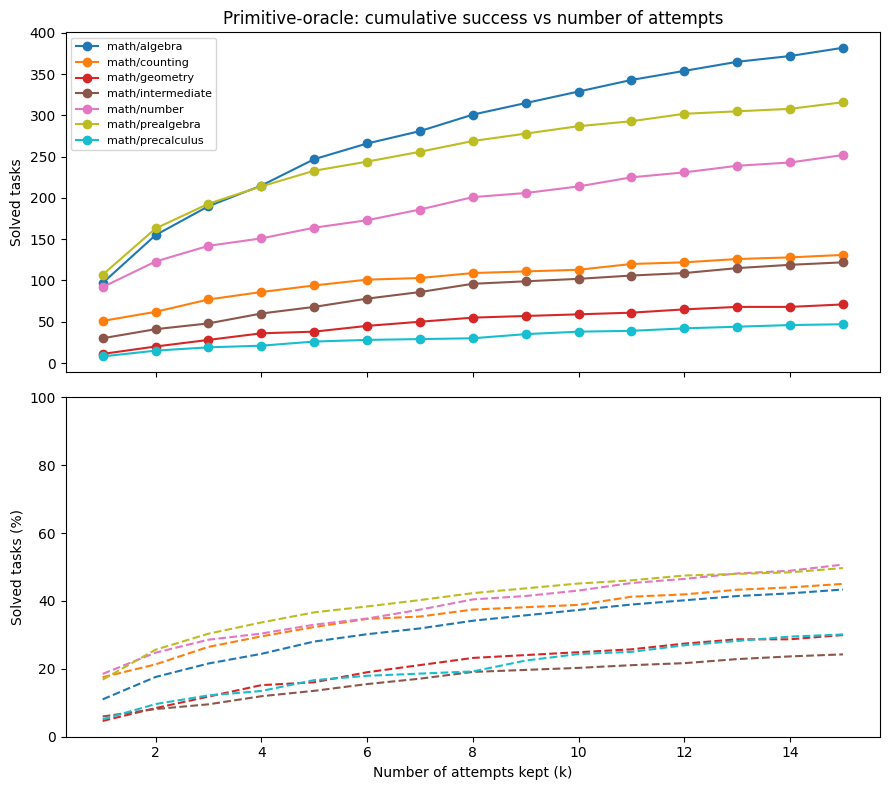

In [24]:
import re
from pathlib import Path
from typing import Dict, List
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt


MAX_N = 15      # maximum attempts per example

# ── 2.  Regex helpers ─────────────────────────────────────────────────────────
EXAMPLE = re.compile(r"##\s*Example\s+\d+.*?(?=##\s*Example|\Z)", re.S | re.I)
ATTEMPT = re.compile(r"\*\*(\d+)-th Execution Result\*\*.*?Is Answer Correct:\s*(True|False)",
                     re.S | re.I)

def first_correct_idx(block: str, n: int = MAX_N) -> int:
    idx = n
    for k, flag in ATTEMPT.findall(block):
        k = int(k)
        if flag.lower() == "true" and k < idx:
            idx = k
    return idx

# ── 3.  Analyse every dataset ─────────────────────────────────────────────────
sampling_counts = OrderedDict()   # ds → array len MAX_N
dataset_sizes   = OrderedDict()

for ds in choices:
    if ds not in md_paths:
        print(f"[warning] {ds}: paths missing – skipped."); continue

    prim_md = md_paths[ds][0]          # first element = primitive oracle
    text    = Path(prim_md).read_text("utf-8")

    first_ok = np.array([first_correct_idx(b) for b in EXAMPLE.findall(text)], dtype=int)
    dataset_sizes[ds] = len(first_ok)
    sampling_counts[ds] = np.array([(first_ok < k).sum() for k in range(1, MAX_N + 1)])

# ── 4.  Plot sampling curves ──────────────────────────────────────────────────
k_vals = np.arange(1, MAX_N + 1)
fig, (ax_cnt, ax_pct) = plt.subplots(2, 1, figsize=(9, 8), sharex=True,
                                     gridspec_kw={"height_ratios": [2, 2]})
colors = plt.cm.get_cmap("tab10", len(sampling_counts))

for i, (ds, counts) in enumerate(sampling_counts.items()):
    c = colors(i)
    ax_cnt.plot(k_vals, counts, "-o", label=ds, color=c)
    ax_pct.plot(k_vals, 100 * counts / dataset_sizes[ds], "--", label=ds, color=c)

ax_cnt.set_ylabel("Solved tasks")
ax_cnt.set_title("Primitive-oracle: cumulative success vs number of attempts")
ax_cnt.legend(fontsize=8)

ax_pct.set_xlabel("Number of attempts kept (k)")
ax_pct.set_ylabel("Solved tasks (%)")
ax_pct.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### Trove-oracle sampling curves (cyclic across its three modes)

#### Sampling schedule
| global sample **k** | mode tested | attempt index within that mode |
|---------------------|-------------|---------------------------------|
| 1 (k = 1)           | **create**  | 0-th attempt |
| 2 (k = 2)           | **import**  | 0-th attempt |
| 3 (k = 3)           | **skip**    | 0-th attempt |
| 4 (k = 4)           | **create**  | 1-st attempt |
| 5 (k = 5)           | **import**  | 1-st attempt |
| 6 (k = 6)           | **skip**    | 1-st attempt |
| ⋮                   | ⋮           | ⋮ |


/tmp/ipykernel_2627246/3751450789.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sampling_counts))


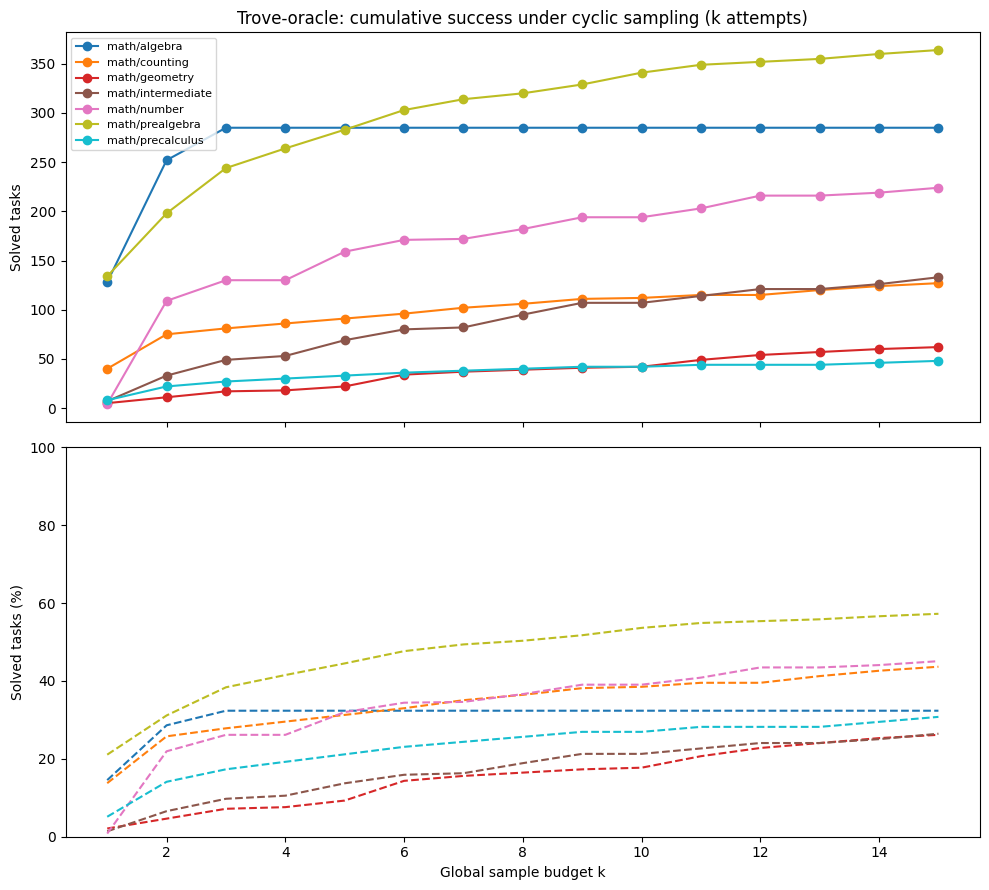

In [28]:
import re
from pathlib import Path
from typing import Dict, List, DefaultDict
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt


MAX_ATTEMPTS_PER_MODE = 5          # labelled 0-th … 5-th inside each block
MODES = ("create", "import", "skip")
NUM_MODES = 3
MAX_K = MAX_ATTEMPTS_PER_MODE * NUM_MODES   # 15 when 5 attempts / mode

# ── 2. regex helpers ──────────────────────────────────────────────────────────
EXAMPLE = re.compile(r"##\s*Example\s+(\d+)(.*?)(?=##\s*Example|\Z)", re.S|re.I)
CORRECT = re.compile(r"Is Answer Correct:\s*True", re.I)
ATTEMPT = re.compile(r"\*\*(\d+)-th Execution Result\*\*", re.I)

def per_mode_first_correct(blocks: List[str]) -> List[int]:
    """Return the earliest correct attempt index for each of the 3 Trove modes."""
    first = [MAX_ATTEMPTS_PER_MODE] * NUM_MODES          # default “no success”

    for mode_id, blk in enumerate(blocks):               # 0 =create, 1 =import, 2 =skip
        if not CORRECT.search(blk):
            continue                                     # this mode never succeeds

        # scan attempts in numerical order until we hit a correct one
        for m in ATTEMPT.finditer(blk):
            attempt_idx = int(m.group(1))                # ← use group(1) from the match
            pat = rf"\*\*{attempt_idx}-th Execution Result\*\*.*?Is Answer Correct:\s*(True|False)"
            if re.search(pat, blk, re.S | re.I).group(1).lower() == "true":
                first[mode_id] = attempt_idx
                break                                    # stop at first correct attempt

    return first

# ── 3. analyse every dataset ─────────────────────────────────────────────────
sampling_counts = OrderedDict()      # ds → array len MAX_K
dataset_sizes   = OrderedDict()

for ds in choices:
    if ds not in md_paths:
        print(f"[warning] {ds}: paths missing – skipped.")
        continue

    trove_md = md_paths[ds][1]        # trove-oracle file
    text     = Path(trove_md).read_text("utf-8")

    # Gather three successive blocks for each example id
    ex_blocks: DefaultDict[int, List[str]] = OrderedDict()
    seen_cnt: DefaultDict[int, int] = defaultdict(int)

    for ex_id_str, blk in EXAMPLE.findall(text):
        ex_id = int(ex_id_str)
        idx   = seen_cnt[ex_id]              # 0:create,1:import,2:skip (assumed order)
        if idx < 3:
            ex_blocks.setdefault(ex_id, [""]*NUM_MODES)[idx] = blk
        seen_cnt[ex_id] += 1

    first_sample_idx = []      # minimal global sample idx per example
    for blks in ex_blocks.values():
        first = per_mode_first_correct(blks)
        # convert to global index: attempt*3 + mode_id
        global_idx = min(a*NUM_MODES+m for m,a in enumerate(first))
        first_sample_idx.append(global_idx)

    first_sample_idx = np.array(first_sample_idx, dtype=int)
    dataset_sizes[ds] = len(first_sample_idx)

    solved_cum = np.array([(first_sample_idx < k).sum()
                           for k in range(1, MAX_K + 1)])
    sampling_counts[ds] = solved_cum

# ── 4. plotting ───────────────────────────────────────────────────────────────
k_vals = np.arange(1, MAX_K + 1)
fig, (ax_cnt, ax_pct) = plt.subplots(2, 1, figsize=(10, 9), sharex=True,
                                     gridspec_kw={'height_ratios':[2,2]})
colors = plt.cm.get_cmap("tab10", len(sampling_counts))

for i, (ds, counts) in enumerate(sampling_counts.items()):
    c = colors(i)
    ax_cnt.plot(k_vals, counts, "-o", label=ds, color=c)
    ax_pct.plot(k_vals, 100*counts/dataset_sizes[ds], "--", label=ds, color=c)

ax_cnt.set_ylabel("Solved tasks")
ax_cnt.set_title("Trove-oracle: cumulative success under cyclic sampling (k attempts)")
ax_cnt.legend(fontsize=8)

ax_pct.set_xlabel("Global sample budget k")
ax_pct.set_ylabel("Solved tasks (%)")
ax_pct.set_ylim(0, 100)

plt.tight_layout()
plt.show()